In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import lang2vec.lang2vec as l2v

In [3]:
# For plots with LaTeX, might give issues depending on your local LaTeX installation
plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsmath} \usepackage{bm}',
    'font.family': 'serif',
})

In [4]:
language_map = {
    "same": "English",
    "avg": "Average",
    "af": "Afrikaans",
    "ar": "Arabic",
    "bg": "Bulgarian",
    "ca": "Catalan",
    "cs": "Czech",
    "da": "Danish",
    "de": "German",
    "el": "Greek",
    "es": "Spanish",
    "fa": "Persian",
    "fi": "Finnish",
    "fr": "French",
    "he": "Hebrew",
    "hi": "Hindi",
    "hu": "Hungarian",
    "it": "Italian",
    "ja": "Japanese",
    "ko": "Korean",
    "lt": "Lithuanian",
    "lv": "Latvian",
    "no": "Norwegian",
    "pl": "Polish",
    "pt": "Portuguese",
    "ro": "Romanian",
    "ru": "Russian",
    "sk": "Slovak",
    "sl": "Slovenian",
    "sv": "Swedish",
    "ta": "Tamil",
    "th": "Thai",
    "tr": "Turkish",
    "uk": "Ukrainian",
    "vi": "Vietnamese",
    "zh": "Chinese",
    "sw": "Swahili",
    "ur": "Urdu",
    "en": "English"
}

method_names = {
    'baseline': 'Fine-tuning Only',
    'before_fastalign': 'Before FastAlign',
    'before_awesome': 'Before Awesome',
    'before_dico': 'Before Dict',
    'during_fastalign': 'During FastAlign',
    'during_awesome': 'During Awesome',
    'during_dico': 'During Dict',
    'freeze_realign_unfreeze_fastalign': 'Before - Front Freeze FastAlign',
    'freeze_realign_unfreeze_awesome': 'Before - Front Freeze Awesome',
    'freeze_realign_unfreeze_dico': 'Before - Front Freeze Dict',
    'freeze_realign_unfreeze_last_6_fastalign': 'Before - Back Freeze FastAlign',
    'freeze_realign_unfreeze_last_half_fastalign': 'Before - Back Freeze FastAlign',
    'freeze_realign_unfreeze_last_6_awesome': 'Before - Back Freeze Awesome',
    'freeze_realign_unfreeze_last_half_awesome': 'Before - Back Freeze Awesome',
    'freeze_realign_unfreeze_last_6_dico': 'Before - Back Freeze Dict',
    'freeze_realign_unfreeze_last_half_dico': 'Before - Back Freeze Dict',
    'during_partial_freeze_front_fastalign': 'During Front Freeze FastAlign',
    'during_partial_freeze_front_awesome': 'During Front Freeze Awesome',
    'during_partial_freeze_front_dico': 'During Front Freeze Dict',
    'during_partial_freeze_back_fastalign': 'During Back Freeze FastAlign',
    'during_partial_freeze_back_awesome': 'During Back Freeze Awesome',
    'during_partial_freeze_back_dico': 'During Back Freeze Dict',
}

lang2vec_mapping = {
    "English": "eng",
    "Afrikaans": "afr",
    "Arabic": "arb",
    "Bulgarian": "bul",
    "Catalan": "cat",
    "Czech": "ces",
    "Danish": "dan",
    "German": "deu",
    "Greek": "ell",
    "Spanish": "spa",
    "Persian": "fas",
    "Finnish": "fin",
    "French": "fra",
    "Hebrew": "heb",
    "Hindi": "hin",
    "Hungarian": "hun",
    "Italian": "ita",
    "Japanese": "jpn",
    "Korean": "kor",
    "Lithuanian": "lit",
    "Latvian": "lav",
    "Norwegian": "nob",
    "Polish": "pol",
    "Portuguese": "por",
    "Romanian": "ron",
    "Russian": "rus",
    "Slovak": "slk",
    "Slovenian": "slv",
    "Swedish": "swe",
    "Tamil": "tam",
    "Thai": "tha",
    "Turkish": "tur",
    "Ukrainian": "ukr",
    "Vietnamese": "vie",
    "Chinese": "cmn"
}

In [5]:
def get_lang_distances(lang1, lang2, mapping):
    if lang1 == 'English' and lang2 == 'English':
        return {'syntactic': 0, 'geographic': 0, 'phonological': 0, 'genetic': 0, 'inventory': 0, 'featural': 0}
    lang2_code = mapping.get(lang2)
    
    if not lang2_code:
        print(f"Error: {lang2} is not in the language mapping.")
        return {k: np.nan for k in ['syntactic', 'geographic', 'phonological', 'genetic', 'inventory', 'featural']}
    
    try:
        distances = {
            'syntactic': l2v.distance('syntactic', lang1, lang2_code),
            'geographic': l2v.distance('geographic', lang1, lang2_code),
            'phonological': l2v.distance('phonological', lang1, lang2_code),
            'genetic': l2v.distance('genetic', lang1, lang2_code),
            'inventory': l2v.distance('inventory', lang1, lang2_code),
            'featural': l2v.distance('featural', lang1, lang2_code),
        }
    except Exception as e:
        print(f"Error calculating distances between {lang1} and {lang2_code}: {e}")
        distances = {k: np.nan for k in ['syntactic', 'geographic', 'phonological', 'genetic', 'inventory', 'featural']}
    
    return distances

def add_language_distances_to_df(df, target_lang='eng', lang_col='language'):
    # Initialize distance columns
    distance_cols = ['syntactic', 'geographic', 'phonological', 'genetic', 'inventory', 'featural']
    for col in distance_cols:
        df[col] = np.nan

    for lang in df[lang_col].unique():
        distances = get_lang_distances(target_lang, lang, lang2vec_mapping)
        for col, value in distances.items():
            df.loc[df[lang_col] == lang, col] = value
    
    return df

def read_and_process_csv(file_path, model_name):
    df = pd.read_csv(file_path)
    records = []
    
    for idx, row in df.iterrows():
        method = row['method']
        seed = row['seed']
        for lang, lang_name in language_map.items():
            if lang_name.lower() == 'average':
                continue  # Skip the 'average' language
            accuracy_key = f'eval_{lang}_accuracy'
            if accuracy_key in df.columns:
                accuracy = row[accuracy_key]
                record = {
                    'model': model_name,
                    'method': method_names.get(method, method),
                    'language': lang_name,
                    'seed': seed,
                    'accuracy': accuracy if not pd.isna(accuracy) else None
                }
                records.append(record)
    
    df_records = pd.DataFrame(records)
    return df_records

def calculate_delta_accuracy(group):
    baseline = group[group['method'] == 'Fine-tuning Only']
    methods = group[group['method'] != 'Fine-tuning Only']
    
    if len(baseline) > 0:
        baseline_accuracy = baseline['accuracy'].values
        
        for method in methods['method'].unique():
            method_indices = methods['method'] == method
            baseline_subset = baseline_accuracy[:sum(method_indices)]
            methods.loc[method_indices, 'delta_accuracy'] = methods.loc[method_indices, 'accuracy'].values - baseline_subset

    return pd.concat([baseline, methods])

def process_dataframe(df, group_by_columns):
    result = df.groupby(group_by_columns, group_keys=False).apply(calculate_delta_accuracy)
    return result.reset_index(drop=True)

def split_method_column(df):
    # Create new columns
    df['aligner'] = ''
    df['freeze_config'] = 'Not Frozen'  # Default to 'Not Frozen'

    # Define mapping for aligners
    aligner_map = {
        'FastAlign': 'FastAlign',
        'Awesome': 'Awesome',
        'Dict': 'Dict'
    }

    # Split the method column
    for idx, row in df.iterrows():
        method = row['method']
        
        # Extract aligner
        for key, value in aligner_map.items():
            if key in method:
                df.at[idx, 'aligner'] = value
                break
        
        # Determine freeze configuration
        if 'Front' in method:
            df.at[idx, 'freeze_config'] = 'Front Frozen'
        elif 'Back' in method:
            df.at[idx, 'freeze_config'] = 'Back Frozen'
        # 'Not Frozen' is already the default, so we don't need an else clause
    
    # Drop the original 'method' column
    df = df.drop('method', axis=1)
    
    return df

def calculate_delta_accuracy(group):
    baseline = group[group['method'] == 'Fine-tuning Only']
    methods = group[group['method'] != 'Fine-tuning Only']
    
    if len(baseline) > 0:
        baseline_accuracy = baseline['accuracy'].values
        
        for method in methods['method'].unique():
            method_indices = methods['method'] == method
            baseline_subset = baseline_accuracy[:sum(method_indices)]
            methods.loc[method_indices, 'delta_accuracy'] = methods.loc[method_indices, 'accuracy'].values - baseline_subset

    return pd.concat([baseline, methods])

def process_dataframe(df, group_by_columns):
    result = df.groupby(group_by_columns, group_keys=False).apply(calculate_delta_accuracy)
    return result.reset_index(drop=True)

# Function to plot loss curves
def plot_loss_curves(model, X_train, y_train, X_val, y_val):
    train_scores = []
    val_scores = []
    for i in range(1, len(model.estimators_) + 1):
        temp_model = RandomForestRegressor(n_estimators=i, random_state=42)
        temp_model.fit(X_train, y_train)
        train_scores.append(mean_squared_error(y_train, temp_model.predict(X_train)))
        val_scores.append(mean_squared_error(y_val, temp_model.predict(X_val)))
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(model.estimators_) + 1), train_scores, label='Training Loss')
    plt.plot(range(1, len(model.estimators_) + 1), val_scores, label='Validation Loss')
    plt.xlabel('Number of Trees')
    plt.ylabel('Mean Squared Error')
    plt.title('Loss Curves')
    plt.legend()
    plt.show()

# Function to plot actual vs predicted data
def plot_actual_vs_predicted(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    
    # Calculate R2 and MSE
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    
    # Add R2 and MSE to the plot
    plt.text(0.05, 0.95, f'R² = {r2:.4f}', transform=plt.gca().transAxes, verticalalignment='top')
    plt.text(0.05, 0.90, f'MSE = {mse:.4f}', transform=plt.gca().transAxes, verticalalignment='top')
    
    plt.tight_layout()
    plt.show()

# New function to plot feature correlations
def plot_feature_correlations(df, features, title, method='pearson'):
    corr = df[features].corr(method=method)
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f')
    plt.title(f'{method.capitalize()} Correlation Heatmap - {title}')
    plt.tight_layout()
    plt.show()

def split_data(X, y, test_size=0.2, val_size=0.1, random_state=42):
    # First, split off the test set
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Then, split the remaining data into training and validation sets
    val_size_adjusted = val_size / (1 - test_size)  # Adjust validation size
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_size_adjusted, random_state=random_state)
    
    return X_train, X_val, X_test, y_train, y_val, y_test


def tune_random_forest_with_cv(X, y, n_splits=5):
    import warnings
    from sklearn.exceptions import FitFailedWarning
    from sklearn.model_selection import cross_val_score, KFold

    # Define the hyperparameter space
    param_dist = {
        'n_estimators': sp_randint(50, 500),
        'max_depth': sp_randint(10, 100),
        'min_samples_split': sp_randint(2, 20),
        'min_samples_leaf': sp_randint(1, 10),
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False]
    }

    # Create a random forest regressor
    rf = RandomForestRegressor(random_state=42)

    # Use random search to find the best hyperparameters
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FitFailedWarning)
        warnings.filterwarnings("ignore", category=UserWarning)
        
        random_search = RandomizedSearchCV(
            estimator=rf,
            param_distributions=param_dist,
            n_iter=100,
            cv=KFold(n_splits=n_splits, shuffle=True, random_state=42),
            random_state=42,
            n_jobs=-1,
            verbose=1,
            error_score='raise'
        )

        # Fit the random search object to the data
        random_search.fit(X, y)

    print("Best parameters:", random_search.best_params_)
    
    # Get the best model
    best_model = random_search.best_estimator_
    
    # Perform k-fold cross-validation
    cv_scores = cross_val_score(best_model, X, y, cv=KFold(n_splits=n_splits, shuffle=True, random_state=42), scoring='r2')
    
    print(f"Cross-validation R² scores: {cv_scores}")
    print(f"Mean R² score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    return best_model

In [6]:
# Load the data
distilmbert_df = read_and_process_csv('./distilMBERT_percentile_data/distilbert-base-multilingual-cased__opus100.csv', model_name='distilMBERT')
nli_df = read_and_process_csv('./distilMBERT_nli_data/distilbert-base-multilingual-cased__xnli__opus100.csv', model_name='distilMBERT')

# Process the dataframes to calculate delta accuracy
distilmbert_df = process_dataframe(distilmbert_df, group_by_columns=['model', 'seed', 'language'])
nli_df = process_dataframe(nli_df, group_by_columns=['model', 'seed', 'language'])


C:\Users\alith\AppData\Local\Temp\ipykernel_79880\2602938850.py:130: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(group_by_columns, group_keys=False).apply(calculate_delta_accuracy)
C:\Users\alith\AppData\Local\Temp\ipykernel_79880\2602938850.py:130: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(group_by_columns, group_keys=False).apply(calculate_delta_accuracy)


In [7]:
distilmbert_df

,model,method,language,seed,accuracy,delta_accuracy
0,distilMBERT,Fine-tuning Only,Afrikaans,17,0.852558,NaN
1,distilMBERT,Before FastAlign,Afrikaans,17,0.866965,0.014406
2,distilMBERT,Before Awesome,Afrikaans,17,0.865176,0.012618
3,distilMBERT,Before Dict,Afrikaans,17,0.854645,0.002086
4,distilMBERT,During FastAlign,Afrikaans,17,0.862394,0.009836
...,...,...,...,...,...,...
3320,distilMBERT,During Back Freeze Awesome,Vietnamese,66,0.569218,-0.010874
3321,distilMBERT,During Back Freeze Dict,Vietnamese,66,0.586951,0.006859
3322,distilMBERT,Before - Back Freeze FastAlign,Vietnamese,66,0.570724,-0.009368
3323,distilMBERT,Before - Back Freeze Awesome,Vietnamese,66,0.576746,-0.003346


In [8]:
# Display rows with any NA values
na_rows = distilmbert_df[distilmbert_df.isna().any(axis=1)]
print(f"Number of rows with NA values: {len(na_rows)}")
print("\nRows with NA values:")
print(na_rows)

# Optionally, to see which columns contain NA values
na_columns = distilmbert_df.columns[distilmbert_df.isna().any()].tolist()
print("\nColumns with NA values:")
print(na_columns)

# To get a count of NA values in each column
na_counts = distilmbert_df.isna().sum()
print("\nCount of NA values in each column:")
print(na_counts[na_counts > 0])

Number of rows with NA values: 175

Rows with NA values:
            model            method    language  seed  accuracy  \
0     distilMBERT  Fine-tuning Only   Afrikaans    17  0.852558   
19    distilMBERT  Fine-tuning Only      Arabic    17  0.508089   
38    distilMBERT  Fine-tuning Only   Bulgarian    17  0.856652   
57    distilMBERT  Fine-tuning Only     Catalan    17  0.865258   
76    distilMBERT  Fine-tuning Only     Chinese    17  0.650433   
...           ...               ...         ...   ...       ...   
3230  distilMBERT  Fine-tuning Only       Tamil    66  0.519908   
3249  distilMBERT  Fine-tuning Only        Thai    66  0.344658   
3268  distilMBERT  Fine-tuning Only     Turkish    66  0.690678   
3287  distilMBERT  Fine-tuning Only   Ukrainian    66  0.812952   
3306  distilMBERT  Fine-tuning Only  Vietnamese    66  0.580092   

      delta_accuracy  
0                NaN  
19               NaN  
38               NaN  
57               NaN  
76               NaN  


In [9]:
# Clean up the dataframes
for df in [distilmbert_df, nli_df]:
    df.dropna(subset=['accuracy', 'delta_accuracy'], inplace=True)
    df.drop(['model', 'accuracy', 'seed'], axis=1, inplace=True)

distilmbert_df


,method,language,delta_accuracy
1,Before FastAlign,Afrikaans,0.014406
2,Before Awesome,Afrikaans,0.012618
3,Before Dict,Afrikaans,0.002086
4,During FastAlign,Afrikaans,0.009836
5,During Awesome,Afrikaans,0.011823
...,...,...,...
3320,During Back Freeze Awesome,Vietnamese,-0.010874
3321,During Back Freeze Dict,Vietnamese,0.006859
3322,Before - Back Freeze FastAlign,Vietnamese,-0.009368
3323,Before - Back Freeze Awesome,Vietnamese,-0.003346


In [10]:
# Function to remove 'during' methods
def remove_during_methods(df):
    # Create a boolean mask for rows where 'method' does not contain 'during'
    mask = ~df['method'].str.contains('during', case=False)
    
    # Apply the mask to filter the DataFrame in-place
    df.drop(df[~mask].index, inplace=True)
    
    # Reset the index of the filtered DataFrame
    df.reset_index(drop=True, inplace=True)

# Store original shapes
original_distilmbert_shape = distilmbert_df.shape
original_nli_shape = nli_df.shape

# Remove 'during' methods from distilmbert_df
remove_during_methods(distilmbert_df)

# Remove 'during' methods from nli_df
remove_during_methods(nli_df)

# Print info about removed rows
print("DistilmBERT DataFrame:")
print(f"Original shape: {original_distilmbert_shape}")
print(f"Filtered shape: {distilmbert_df.shape}")
print(f"Rows removed: {original_distilmbert_shape[0] - distilmbert_df.shape[0]}")

print("\nNLI DataFrame:")
print(f"Original shape: {original_nli_shape}")
print(f"Filtered shape: {nli_df.shape}")
print(f"Rows removed: {original_nli_shape[0] - nli_df.shape[0]}")

# Display the unique methods remaining in each DataFrame
print("\nRemaining methods in DistilmBERT DataFrame:")
print(distilmbert_df['method'].unique())

print("\nRemaining methods in NLI DataFrame:")
print(nli_df['method'].unique())

DistilmBERT DataFrame:
Original shape: (3150, 3)
Filtered shape: (1575, 3)
Rows removed: 1575

NLI DataFrame:
Original shape: (585, 3)
Filtered shape: (585, 3)
Rows removed: 0

Remaining methods in DistilmBERT DataFrame:
['Before FastAlign' 'Before Awesome' 'Before Dict'
 'Before - Front Freeze FastAlign' 'Before - Front Freeze Awesome'
 'Before - Front Freeze Dict' 'Before - Back Freeze FastAlign'
 'Before - Back Freeze Awesome' 'Before - Back Freeze Dict']

Remaining methods in NLI DataFrame:
['Before FastAlign' 'Before Awesome' 'Before Dict'
 'Before - Front Freeze FastAlign' 'Before - Front Freeze Awesome'
 'Before - Front Freeze Dict' 'Before - Back Freeze FastAlign'
 'Before - Back Freeze Awesome' 'Before - Back Freeze Dict']


In [11]:
# Split the method column
distilmbert_df = split_method_column(distilmbert_df)
nli_df = split_method_column(nli_df)

# Add language distances
distilmbert_df = add_language_distances_to_df(distilmbert_df)
nli_df = add_language_distances_to_df(nli_df)

In [12]:
# Filter out English and Average from DistilmBERT dataframe
distilmbert_df = distilmbert_df[~distilmbert_df['language'].isin(['English', 'Average'])]

# Filter out English and Average from NLI dataframe
nli_df = nli_df[~nli_df['language'].isin(['English', 'Average'])]

# Now let's check the number of rows in each dataframe after filtering
print(f"Number of rows in DistilmBERT dataframe: {len(distilmbert_df)}")
print(f"Number of rows in NLI dataframe: {len(nli_df)}")

# Let's also print the unique languages in each dataframe to confirm the removal
print("\nUnique languages in DistilmBERT dataframe:")
print(distilmbert_df['language'].unique())

print("\nUnique languages in NLI dataframe:")
print(nli_df['language'].unique())

Number of rows in DistilmBERT dataframe: 1530
Number of rows in NLI dataframe: 540

Unique languages in DistilmBERT dataframe:
['Afrikaans' 'Arabic' 'Bulgarian' 'Catalan' 'Chinese' 'Czech' 'Danish'
 'Finnish' 'French' 'German' 'Greek' 'Hebrew' 'Hindi' 'Hungarian'
 'Italian' 'Japanese' 'Korean' 'Latvian' 'Lithuanian' 'Norwegian'
 'Persian' 'Polish' 'Portuguese' 'Romanian' 'Russian' 'Slovak' 'Slovenian'
 'Spanish' 'Swedish' 'Tamil' 'Thai' 'Turkish' 'Ukrainian' 'Vietnamese']

Unique languages in NLI dataframe:
['Arabic' 'Bulgarian' 'Chinese' 'French' 'German' 'Greek' 'Hindi'
 'Russian' 'Spanish' 'Thai' 'Turkish' 'Vietnamese']


In [13]:
# Prepare features and encode categorical variables
features = ['aligner', 'freeze_config', 
            'syntactic', 'geographic', 'phonological', 'genetic', 'inventory', 'featural']

# Encode 'aligner' separately
aligner_encoded = pd.get_dummies(distilmbert_df['aligner'], prefix='aligner', drop_first=False)

# Encode 'freeze_config' separately
freeze_config_encoded = pd.get_dummies(distilmbert_df['freeze_config'], prefix='freeze_config', drop_first=True)

# Combine the encoded columns with the numerical features
distilmbert_encoded = pd.concat([
    aligner_encoded,
    freeze_config_encoded,
    distilmbert_df[['syntactic', 'geographic', 'phonological', 'genetic', 'inventory', 'featural']]
], axis=1)

# Add the target variable to the encoded dataframe
distilmbert_encoded['delta_accuracy'] = distilmbert_df['delta_accuracy']

# Print the columns to verify
print(distilmbert_encoded.columns)

Index(['aligner_Awesome', 'aligner_Dict', 'aligner_FastAlign',
       'freeze_config_Front Frozen', 'freeze_config_Not Frozen', 'syntactic',
       'geographic', 'phonological', 'genetic', 'inventory', 'featural',
       'delta_accuracy'],
      dtype='object')


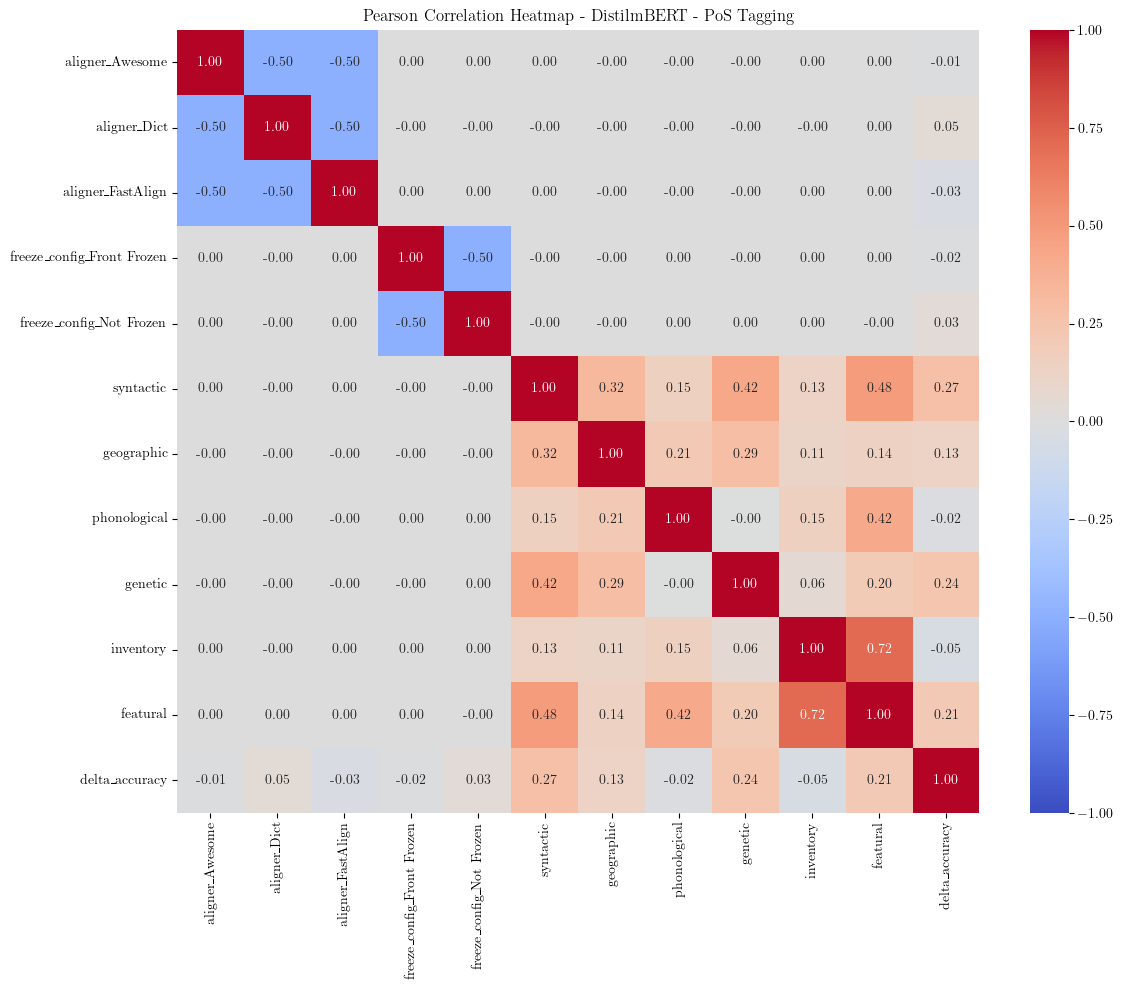

In [14]:
# Plot feature correlations for DistilmBERT
plot_feature_correlations(distilmbert_encoded, distilmbert_encoded.columns, 'DistilmBERT - PoS Tagging')

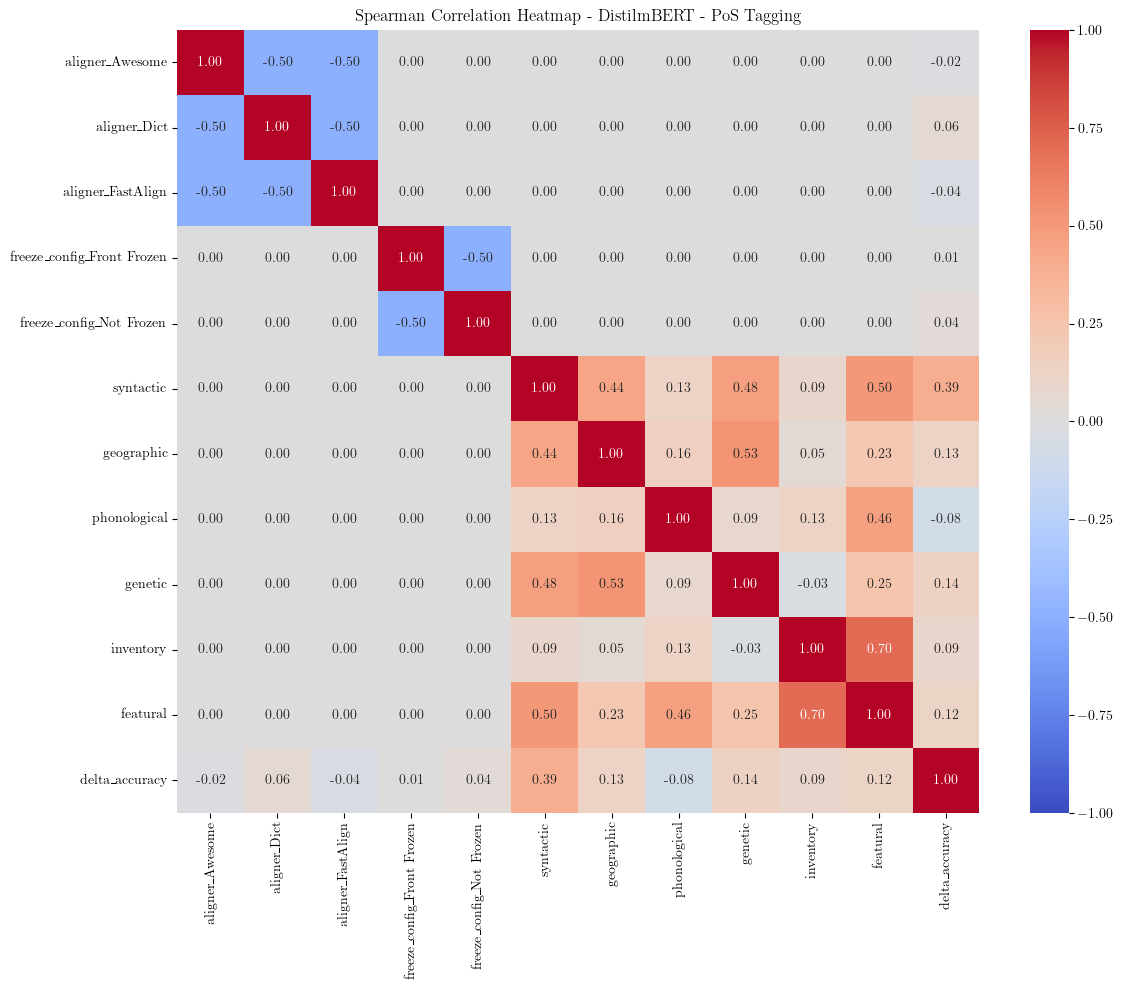

In [15]:
# Plot feature correlations for DistilmBERT
plot_feature_correlations(distilmbert_encoded, distilmbert_encoded.columns, 'DistilmBERT - PoS Tagging', method='spearman')

Tuning DistilmBERT model with cross-validation...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'bootstrap': True, 'max_depth': 96, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 409}
Cross-validation R² scores: [0.8824221  0.85082785 0.84491394 0.88255299 0.85693204]
Mean R² score: 0.8635 (+/- 0.0319)
DistilmBERT Test R² score: 0.8966


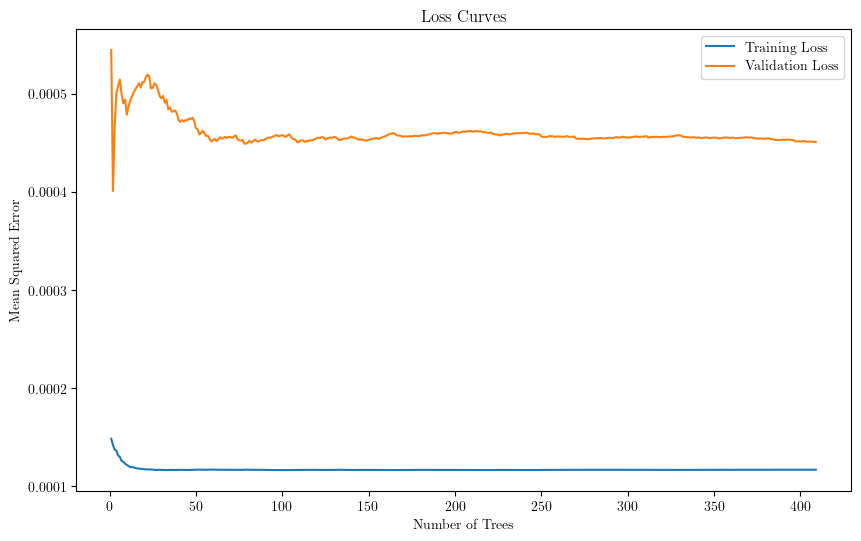

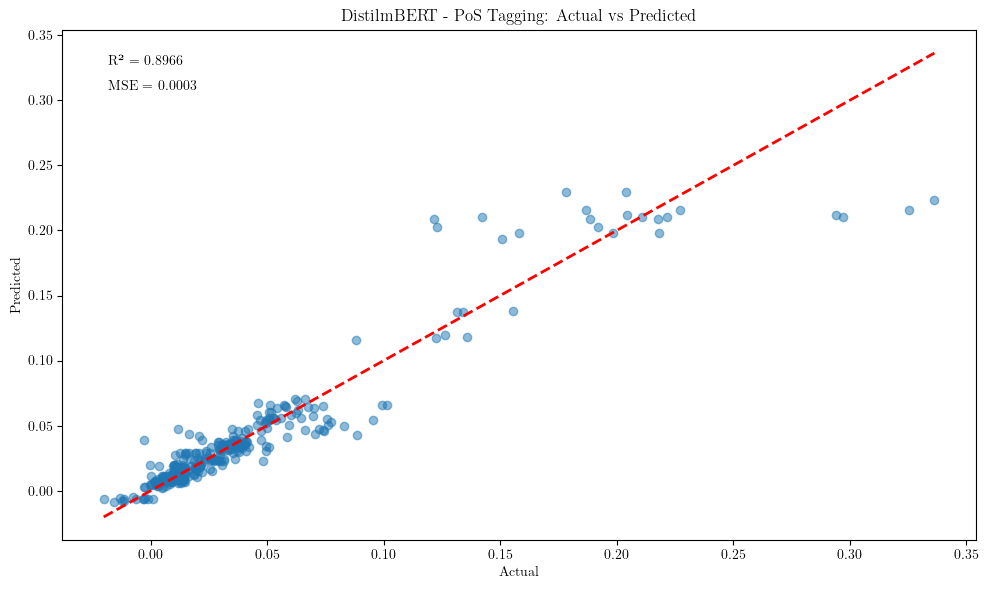

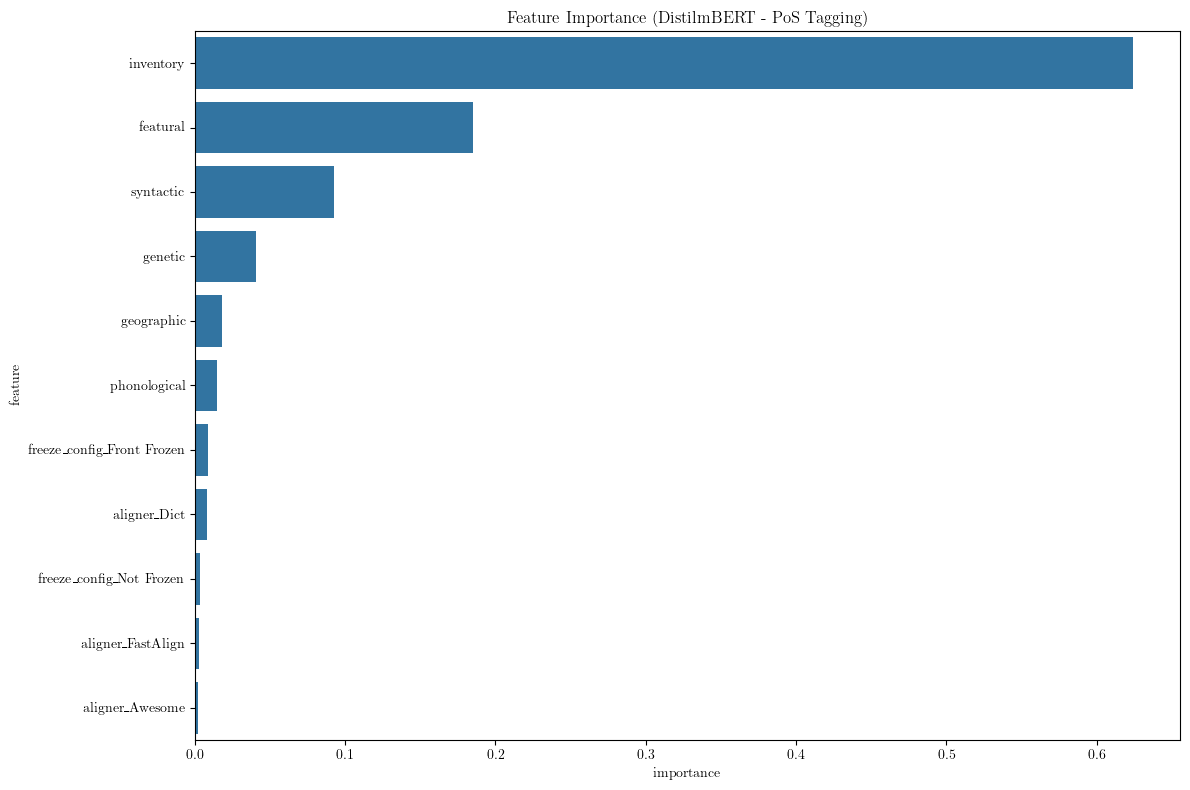

In [16]:
# Prepare data for DistilmBERT regression
X_distilmbert = distilmbert_encoded.drop('delta_accuracy', axis=1)
y_distilmbert = distilmbert_encoded['delta_accuracy']

# Split DistilmBERT data into train, validation, and test sets
X_train_distilmbert, X_val_distilmbert, X_test_distilmbert, y_train_distilmbert, y_val_distilmbert, y_test_distilmbert = split_data(X_distilmbert, y_distilmbert)

# Tune and train DistilmBERT model
print("Tuning DistilmBERT model with cross-validation...")
model_distilmbert = tune_random_forest_with_cv(X_distilmbert, y_distilmbert)

# Make DistilmBERT predictions on test set
y_pred_distilmbert = model_distilmbert.predict(X_test_distilmbert)

# Evaluate on test set
test_score_distilmbert = model_distilmbert.score(X_test_distilmbert, y_test_distilmbert)
print(f"DistilmBERT Test R² score: {test_score_distilmbert:.4f}")

# Plot DistilmBERT results
plot_loss_curves(model_distilmbert, X_train_distilmbert, y_train_distilmbert, X_val_distilmbert, y_val_distilmbert)
plot_actual_vs_predicted(y_test_distilmbert, y_pred_distilmbert, 'DistilmBERT - PoS Tagging: Actual vs Predicted')

# Calculate feature importance
feature_importance_distilmbert = pd.DataFrame({'feature': X_distilmbert.columns, 'importance': model_distilmbert.feature_importances_})
feature_importance_distilmbert = feature_importance_distilmbert.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_distilmbert)
plt.title('Feature Importance (DistilmBERT - PoS Tagging)')
plt.tight_layout()
plt.show()

In [17]:
X_train_distilmbert

,aligner_Awesome,aligner_Dict,aligner_FastAlign,freeze_config_Front Frozen,freeze_config_Not Frozen,syntactic,geographic,phonological,genetic,inventory,featural
305,False,True,False,False,False,0.51,0.1,0.5687,0.9000,0.4661,0.5
104,False,True,False,True,False,0.52,0.1,0.1950,0.8333,0.5516,0.5
421,True,False,False,False,False,0.52,0.1,0.1950,0.8333,0.5516,0.5
842,False,True,False,True,False,0.47,0.1,0.5687,0.9000,0.4235,0.5
17,False,True,False,False,False,0.67,0.2,0.5687,1.0000,0.5983,0.8
...,...,...,...,...,...,...,...,...,...,...,...
1404,False,False,True,False,True,0.66,0.5,0.5032,1.0000,0.5472,0.6
710,False,True,False,False,False,0.53,0.1,0.2736,1.0000,0.4694,0.5
818,False,True,False,False,False,0.52,0.1,0.4477,1.0000,0.4769,0.5
50,False,True,False,True,False,0.66,0.1,0.5687,0.9000,0.5368,0.6


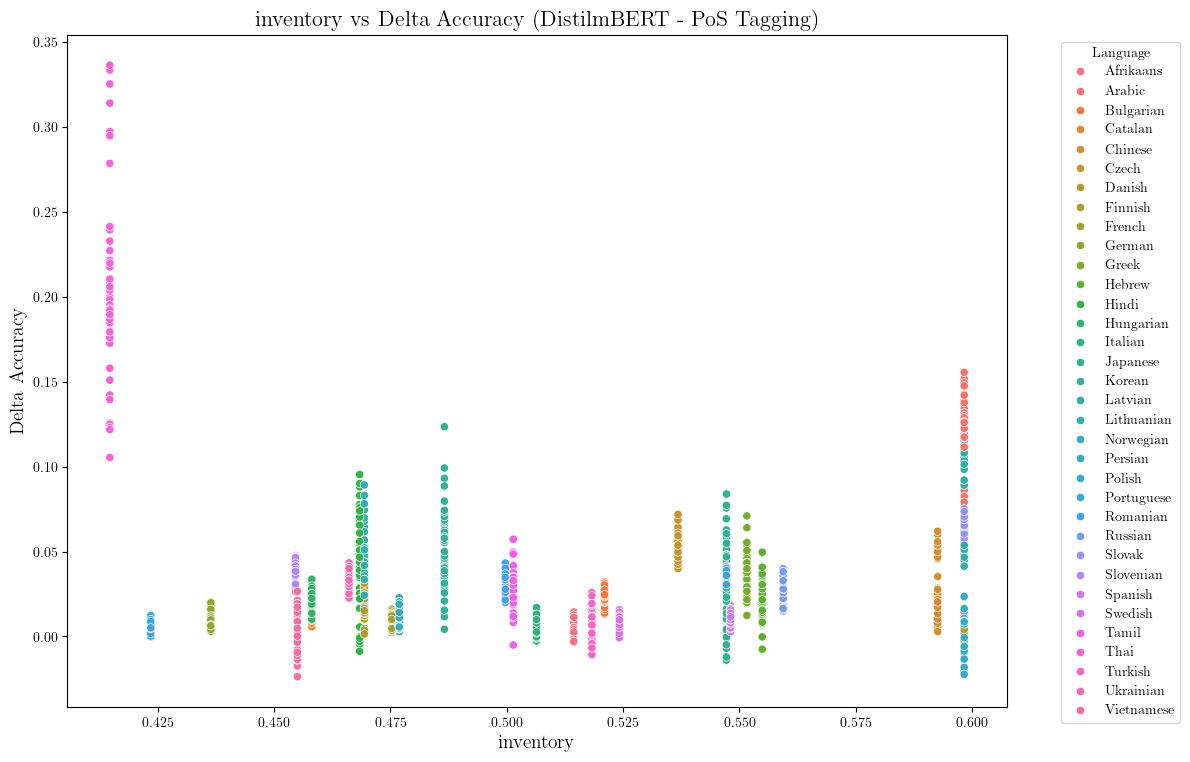

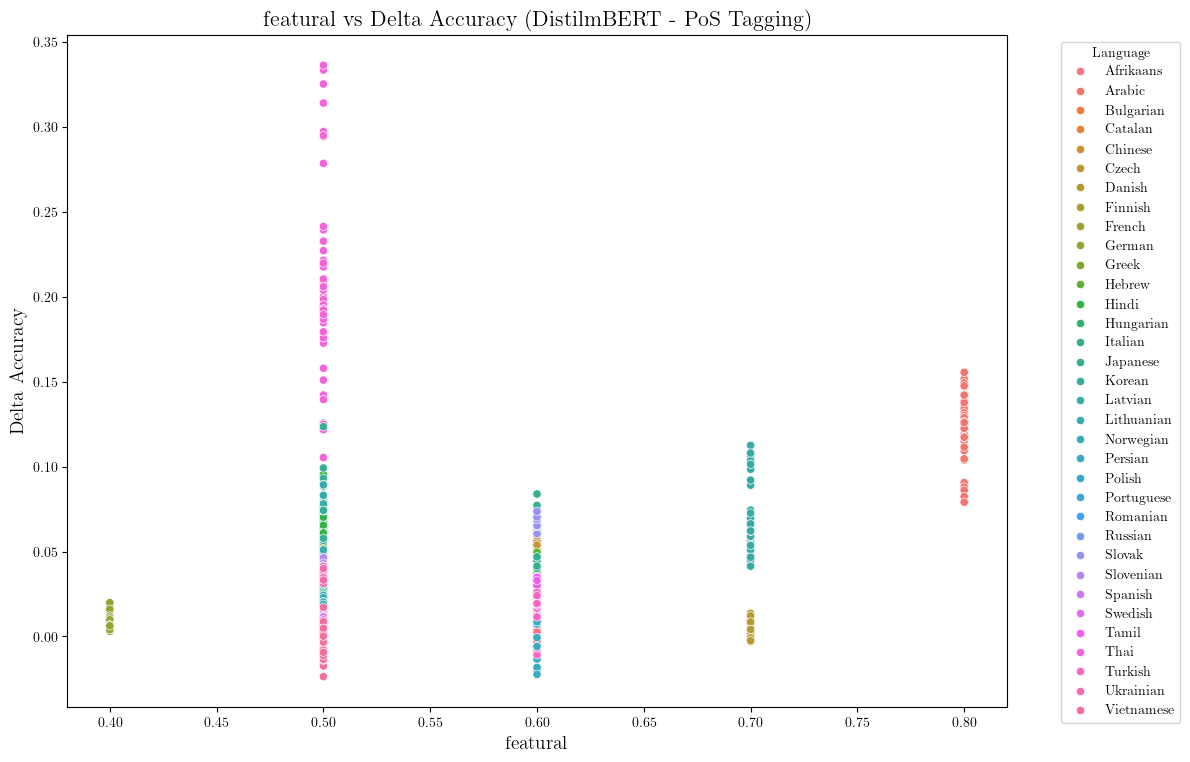

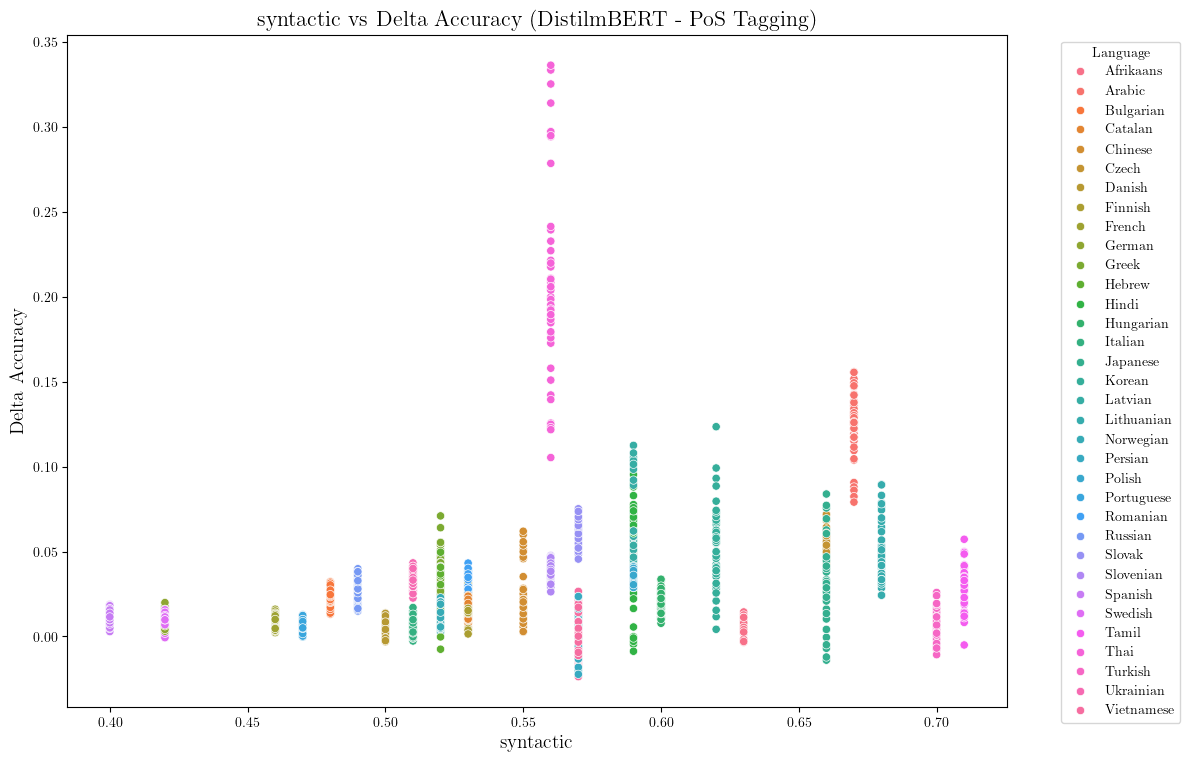

In [18]:
# Get top 3 features
top_3_features = feature_importance_distilmbert['feature'].head(3).tolist()

# Create separate scatter plots for top 3 features vs delta accuracy
for feature in top_3_features:
    plt.figure(figsize=(12, 8))
    scatter = sns.scatterplot(data=distilmbert_df, x=feature, y='delta_accuracy', hue='language')
    plt.title(f'{feature} vs Delta Accuracy (DistilmBERT - PoS Tagging)', fontsize=16)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Delta Accuracy', fontsize=14)
    
    # Adjust legend
    scatter.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    plt.tight_layout()
    plt.show()

Index(['aligner_Awesome', 'aligner_Dict', 'aligner_FastAlign',
       'freeze_config_Front Frozen', 'freeze_config_Not Frozen', 'syntactic',
       'geographic', 'phonological', 'genetic', 'inventory', 'featural',
       'delta_accuracy'],
      dtype='object')
Tuning NLI model with cross-validation...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'bootstrap': False, 'max_depth': 58, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 19, 'n_estimators': 145}
Cross-validation R² scores: [0.91513998 0.9105576  0.90318485 0.84335062 0.91044575]
Mean R² score: 0.8965 (+/- 0.0537)
NLI Test R² score: 0.9237


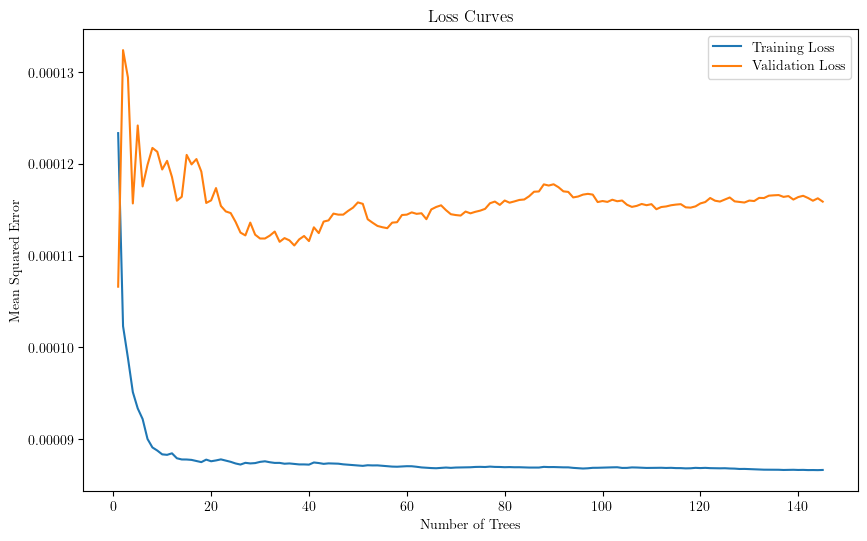

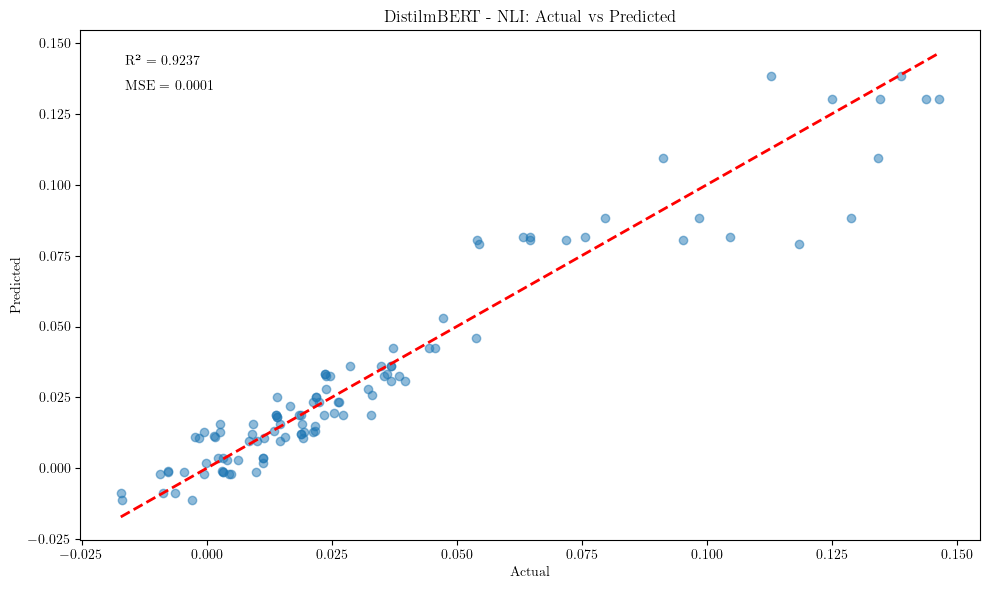

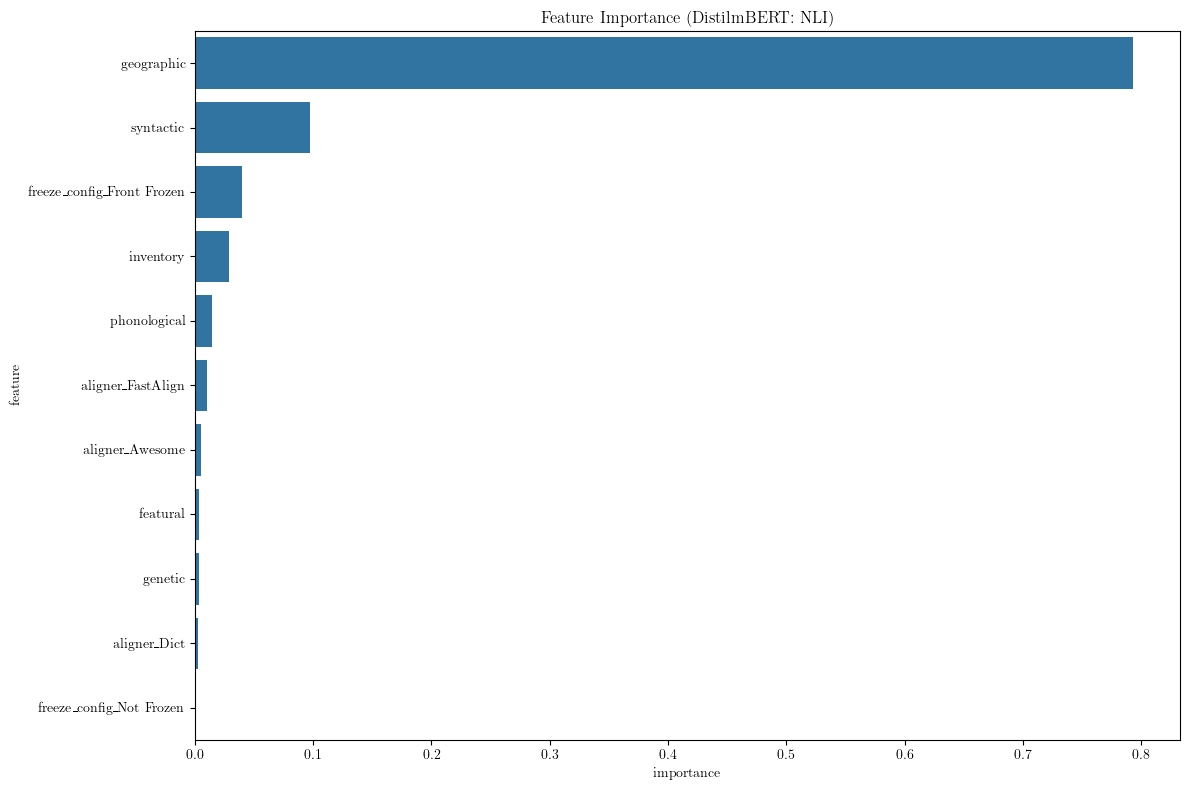

In [19]:
# Encode 'aligner' separately
aligner_encoded = pd.get_dummies(nli_df['aligner'], prefix='aligner', drop_first=False)

# Encode 'freeze_config' separately
freeze_config_encoded = pd.get_dummies(nli_df['freeze_config'], prefix='freeze_config', drop_first=True)

# Combine the encoded columns with the numerical features
nli_encoded = pd.concat([
    aligner_encoded,
    freeze_config_encoded,
    nli_df[['syntactic', 'geographic', 'phonological', 'genetic', 'inventory', 'featural']]
], axis=1)

# Add the target variable to the encoded dataframe
nli_encoded['delta_accuracy'] = nli_df['delta_accuracy']

# Print the columns to verify
print(nli_encoded.columns)

# Prepare data for NLI regression
X_nli = nli_encoded.drop('delta_accuracy', axis=1)
y_nli = nli_encoded['delta_accuracy']

# Split NLI data into train, validation, and test sets
X_train_nli, X_val_nli, X_test_nli, y_train_nli, y_val_nli, y_test_nli = split_data(X_nli, y_nli)

# Tune and train NLI model
print("Tuning NLI model with cross-validation...")
model_nli = tune_random_forest_with_cv(X_nli, y_nli)

# Make NLI predictions on test set
y_pred_nli = model_nli.predict(X_test_nli)

# Evaluate on test set
test_score_nli = model_nli.score(X_test_nli, y_test_nli)
print(f"NLI Test R² score: {test_score_nli:.4f}")

# Plot NLI results
plot_loss_curves(model_nli, X_train_nli, y_train_nli, X_val_nli, y_val_nli)
plot_actual_vs_predicted(y_test_nli, y_pred_nli, 'DistilmBERT - NLI: Actual vs Predicted')

# NLI feature importance
feature_importance_nli = pd.DataFrame({'feature': X_nli.columns, 'importance': model_nli.feature_importances_})
feature_importance_nli = feature_importance_nli.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_nli)
plt.title('Feature Importance (DistilmBERT: NLI)')
plt.tight_layout()
plt.show()

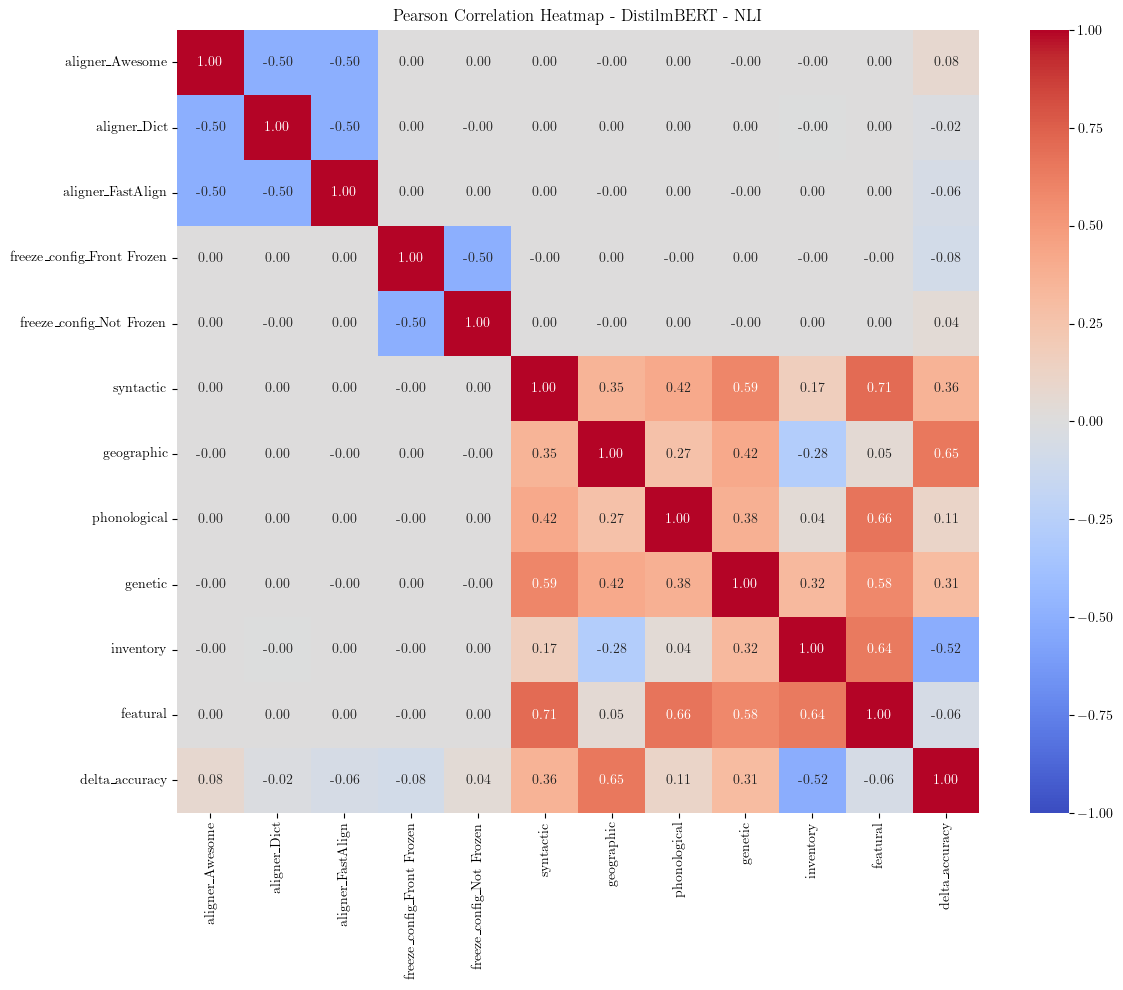

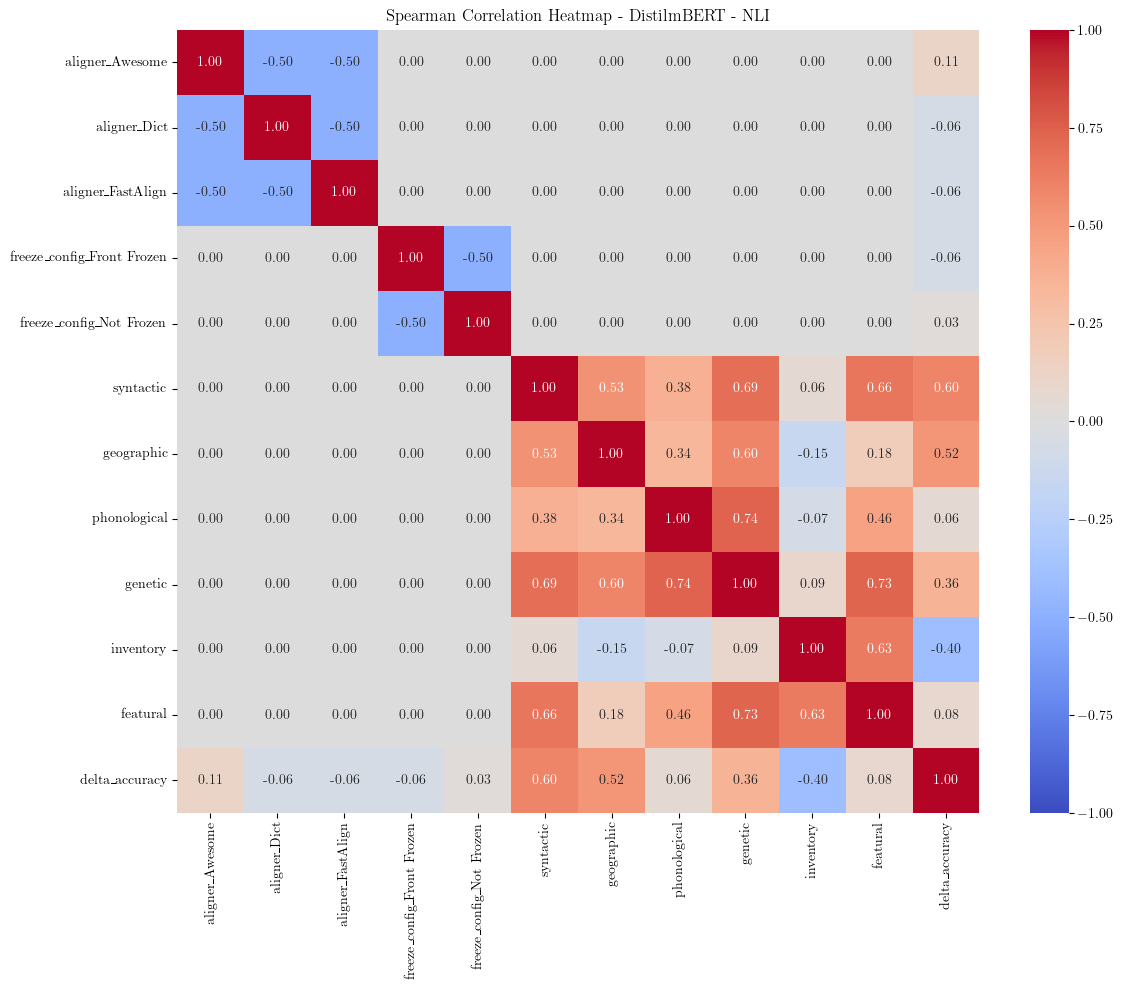

In [20]:
# Plot feature correlations for NLI
plot_feature_correlations(nli_encoded, nli_encoded.columns, 'DistilmBERT - NLI')

# Plot feature correlations for NLI using Spearman correlation
plot_feature_correlations(nli_encoded, nli_encoded.columns, 'DistilmBERT - NLI', method='spearman')

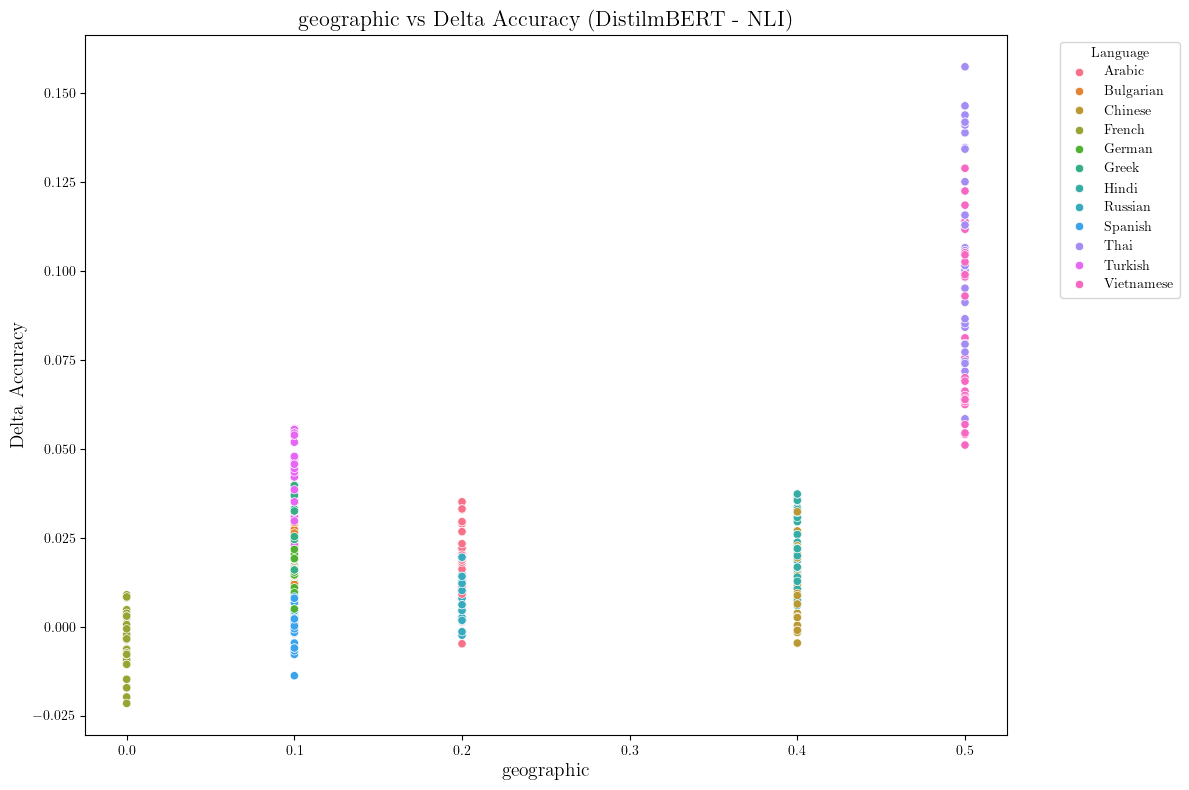

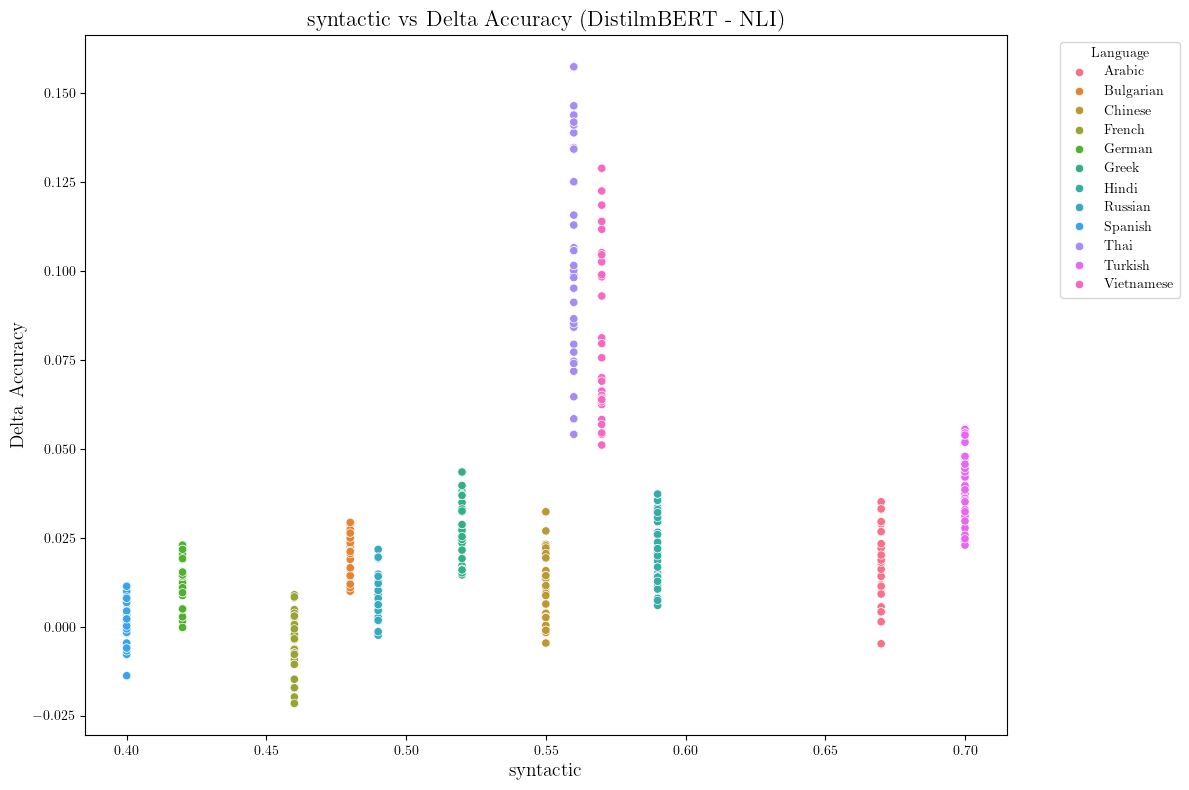

In [21]:
# Get top 2 features
top_2_features = feature_importance_nli['feature'].head(2).tolist()

# Create separate scatter plots for top 2 features vs delta accuracy
for feature in top_2_features:
    plt.figure(figsize=(12, 8))
    scatter = sns.scatterplot(data=nli_df, x=feature, y='delta_accuracy', hue='language')
    plt.title(f'{feature} vs Delta Accuracy (DistilmBERT - NLI)', fontsize=16)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Delta Accuracy', fontsize=14)
    
    # Adjust legend
    scatter.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    plt.tight_layout()
    plt.show()

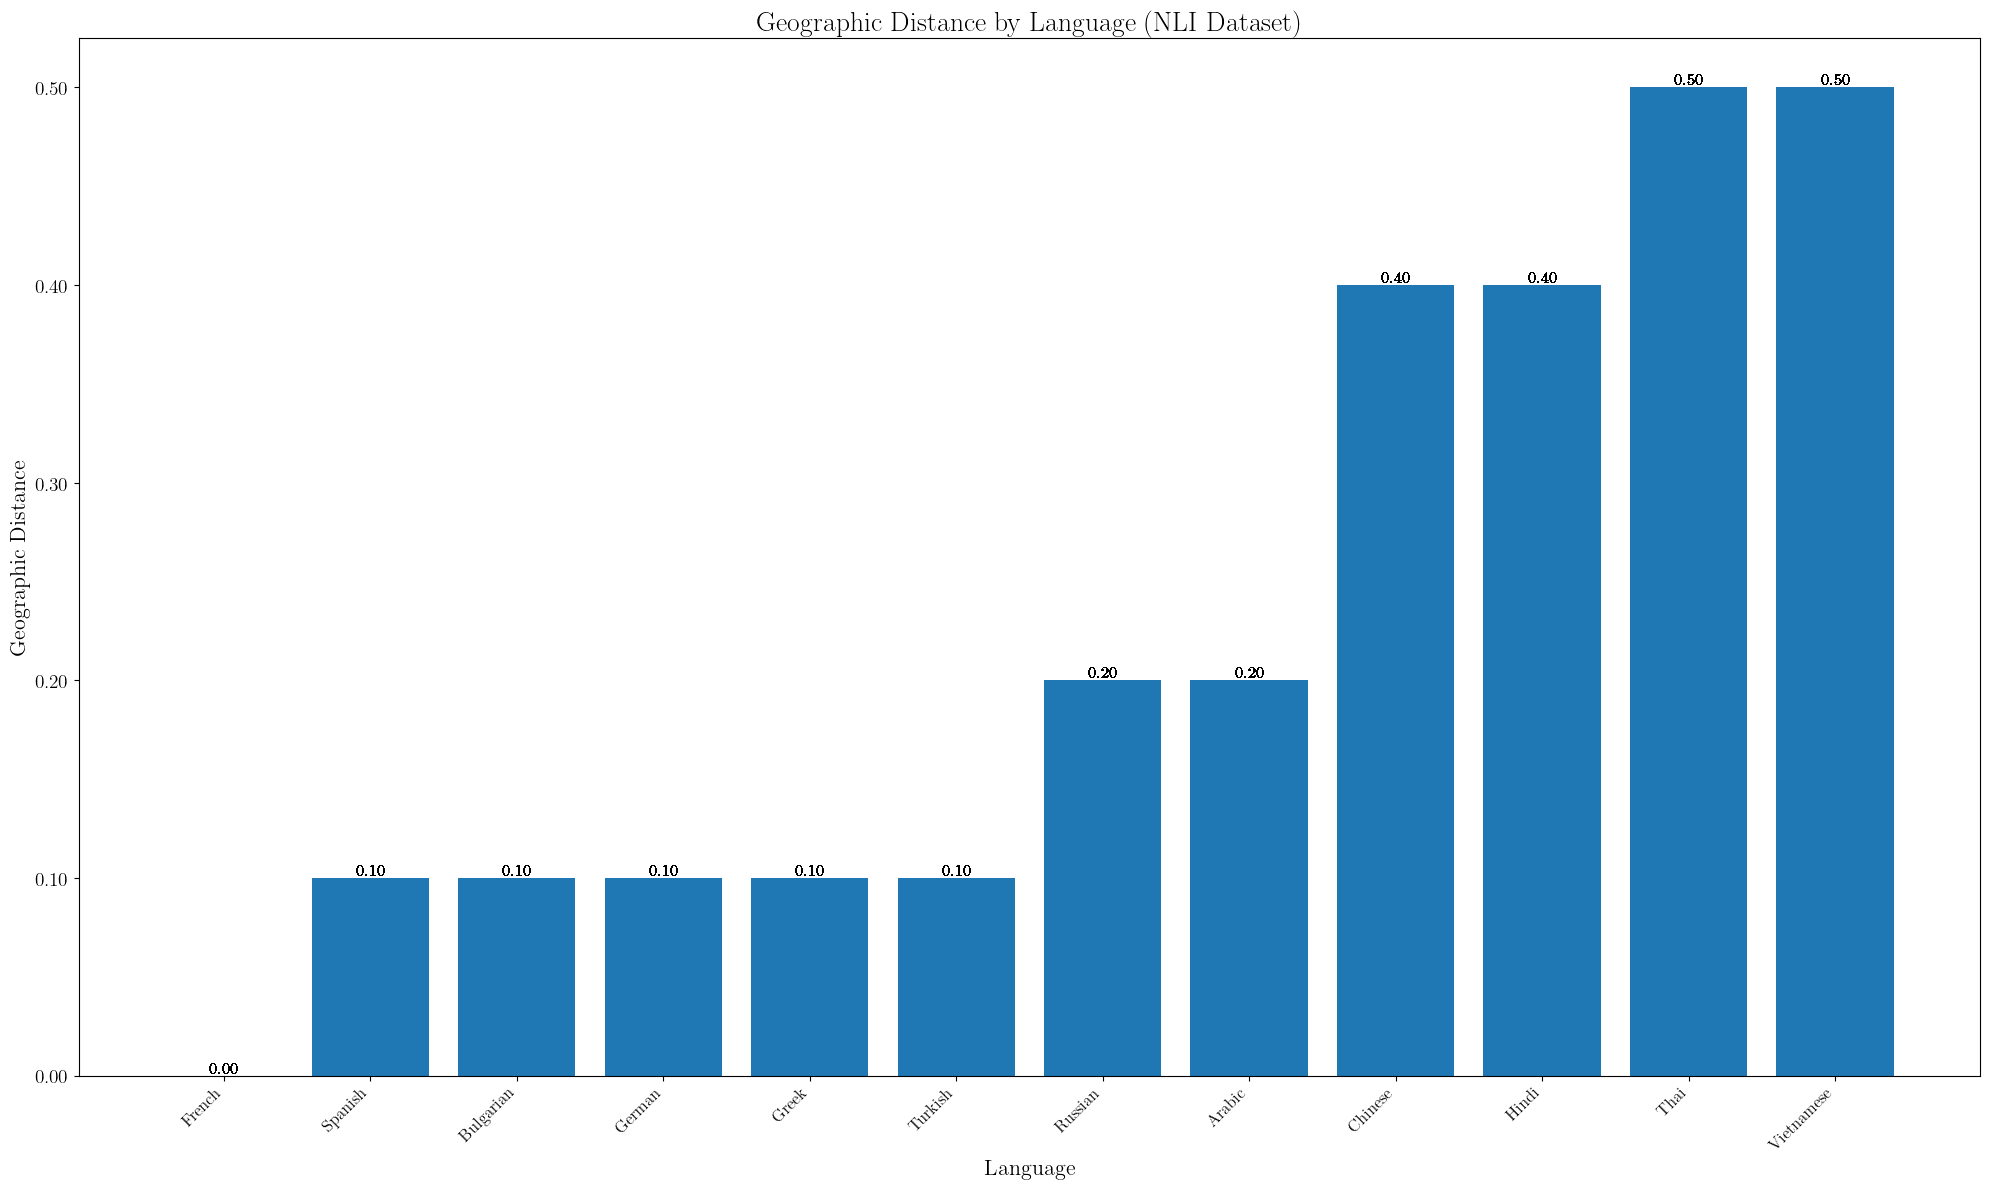

In [29]:
# Sort the dataframe by geographic value for better visualization
sorted_df = nli_df.sort_values('geographic')

# Create a bar plot
plt.figure(figsize=(20, 12))  # Increased figure size
bars = plt.bar(sorted_df['language'], sorted_df['geographic'])

# Customize the plot
plt.title('Geographic Distance by Language (NLI Dataset)', fontsize=20)
plt.xlabel('Language', fontsize=16)
plt.ylabel('Geographic Distance', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Adjusted rotation and increased font size
plt.yticks(fontsize=14)  # Increased y-axis tick font size further

# Format y-axis ticks
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f}'))

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=12,  # Increased font size further
             rotation=0, fontweight='bold')  # Made text bold

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [24]:
# Load and process the XLM-R data
xlmr_pos_df = read_and_process_csv('./results/xlm-roberta-base/POS/QE-filtering/opus100_filtered_0.0.csv', model_name='XLM-R')
xlmr_nli_df = read_and_process_csv('./raw_results/xlm-roberta-base__opus100.csv', model_name='XLM-R')

# Process the dataframes to calculate delta accuracy
xlmr_pos_df = process_dataframe(xlmr_pos_df, group_by_columns=['model', 'seed', 'language'])
xlmr_nli_df = process_dataframe(xlmr_nli_df, group_by_columns=['model', 'seed', 'language'])

# Clean up the dataframes
for df in [xlmr_pos_df, xlmr_nli_df]:
    df.dropna(subset=['accuracy', 'delta_accuracy'], inplace=True)
    df.drop(['model', 'accuracy', 'seed'], axis=1, inplace=True)

# Remove 'during' methods
remove_during_methods(xlmr_pos_df)
remove_during_methods(xlmr_nli_df)

# Split the method column
xlmr_pos_df = split_method_column(xlmr_pos_df)
xlmr_nli_df = split_method_column(xlmr_nli_df)

# Add language distances
xlmr_pos_df = add_language_distances_to_df(xlmr_pos_df)
xlmr_nli_df = add_language_distances_to_df(xlmr_nli_df)

# Filter out English and Average
xlmr_pos_df = xlmr_pos_df[~xlmr_pos_df['language'].isin(['English', 'Average'])]
xlmr_nli_df = xlmr_nli_df[~xlmr_nli_df['language'].isin(['English', 'Average'])]


C:\Users\alith\AppData\Local\Temp\ipykernel_11576\2602938850.py:130: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(group_by_columns, group_keys=False).apply(calculate_delta_accuracy)
C:\Users\alith\AppData\Local\Temp\ipykernel_11576\2602938850.py:130: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(group_by_columns, group_keys=False).apply(calculate_delta_accuracy)


In [28]:
# First, ensure that both dataframes have the same languages
assert set(xlmr_pos_df['language']) == set(xlmr_nli_df['language']), "POS and NLI dataframes have different languages"

# Create a list of the language distance features
lang_distance_features = ['syntactic', 'geographic', 'phonological', 'genetic', 'inventory', 'featural']

# For each language, check if the distance features are the same in both dataframes
for language in xlmr_pos_df['language'].unique():
    pos_values = xlmr_pos_df[xlmr_pos_df['language'] == language][lang_distance_features].iloc[0]
    nli_values = xlmr_nli_df[xlmr_nli_df['language'] == language][lang_distance_features].iloc[0]
    
    assert pos_values.equals(nli_values), f"Language distance features for {language} are not consistent between POS and NLI dataframes"

print("Assertion passed: Language distance features are consistent between POS and NLI dataframes for all languages.")

Assertion passed: Language distance features are consistent between POS and NLI dataframes for all languages.


Index(['aligner_Awesome', 'aligner_Dict', 'aligner_FastAlign',
       'freeze_config_Front Frozen', 'freeze_config_Not Frozen', 'syntactic',
       'geographic', 'phonological', 'genetic', 'inventory', 'featural',
       'delta_accuracy'],
      dtype='object')


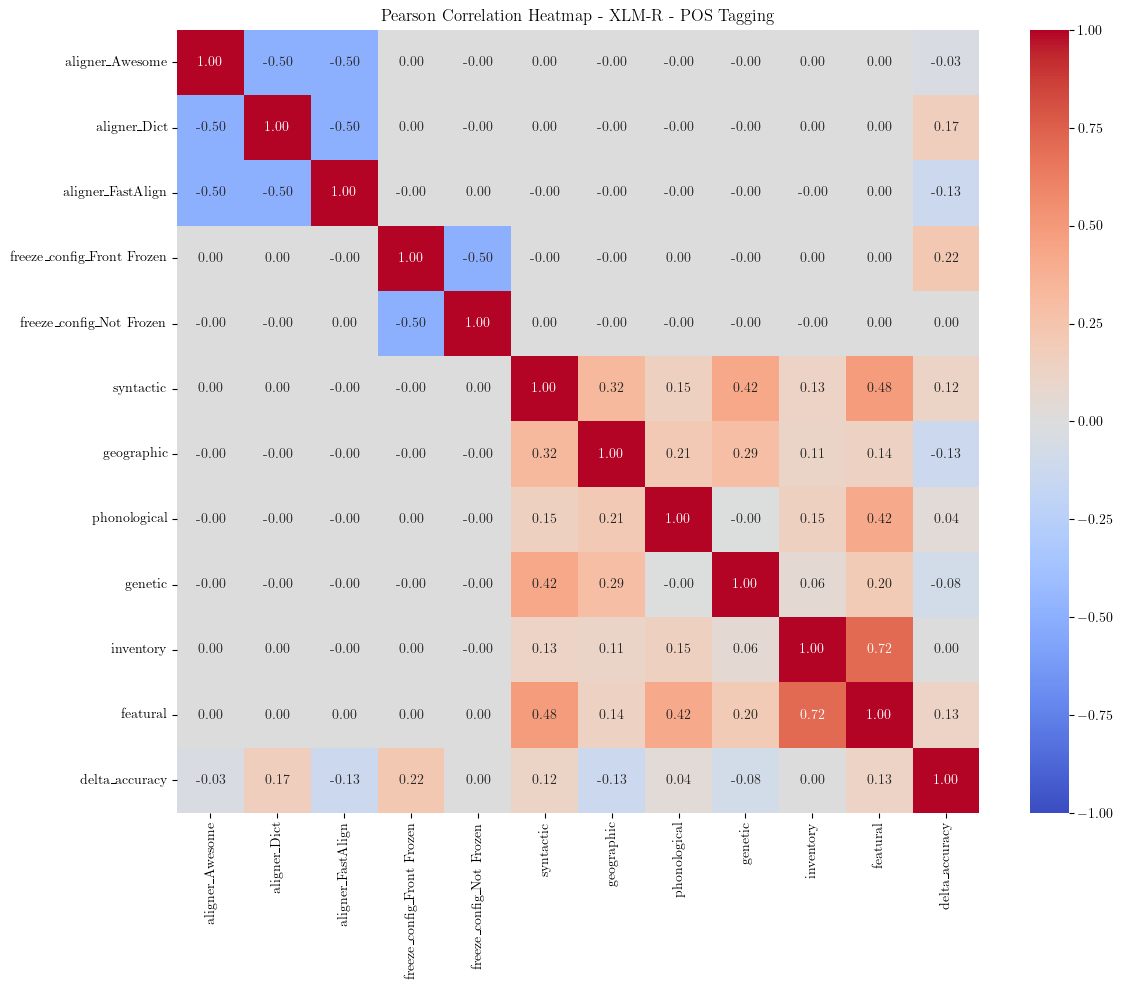

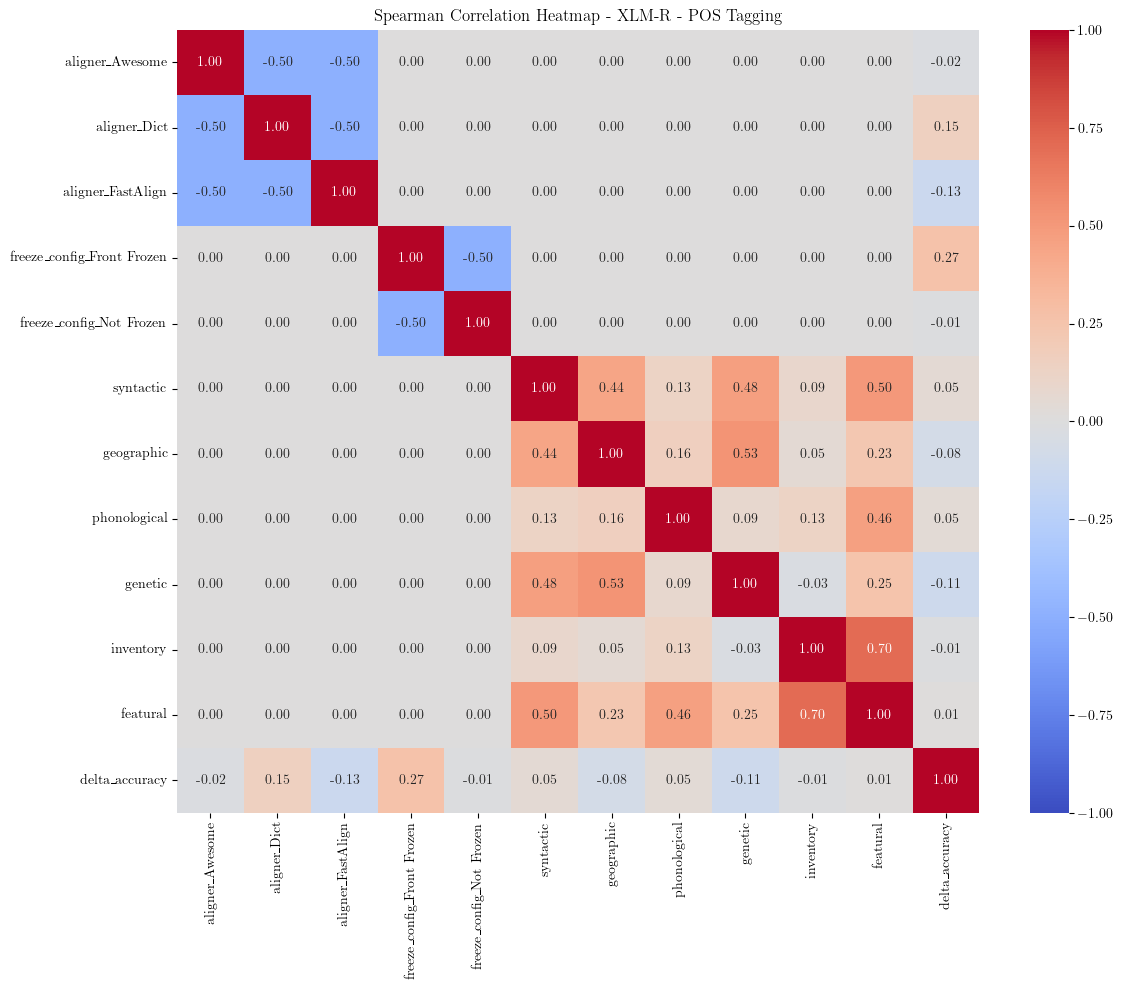

Tuning XLM-R POS tagging model with cross-validation...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'bootstrap': False, 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 18, 'n_estimators': 489}
Cross-validation R² scores: [0.47886618 0.39042927 0.41714429 0.40717634 0.46128868]
Mean R² score: 0.4310 (+/- 0.0670)
XLM-R POS Tagging Test R² score: 0.5890


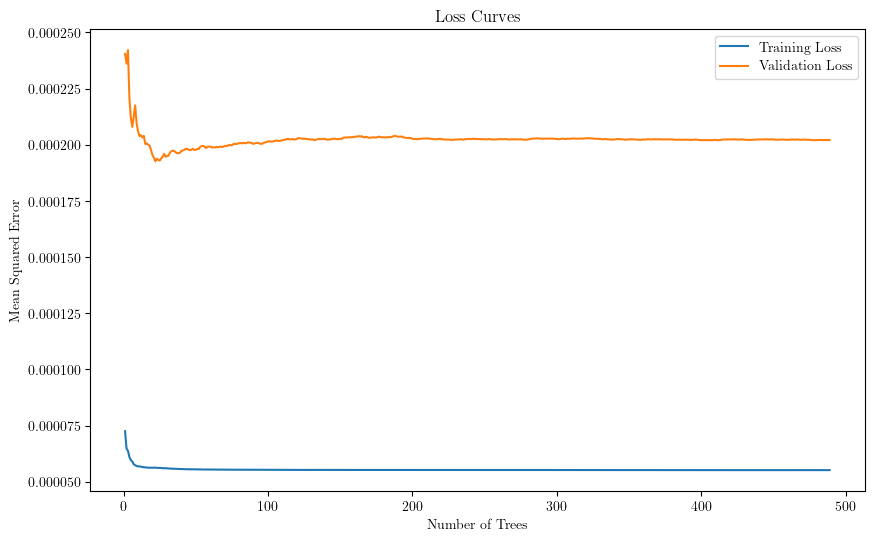

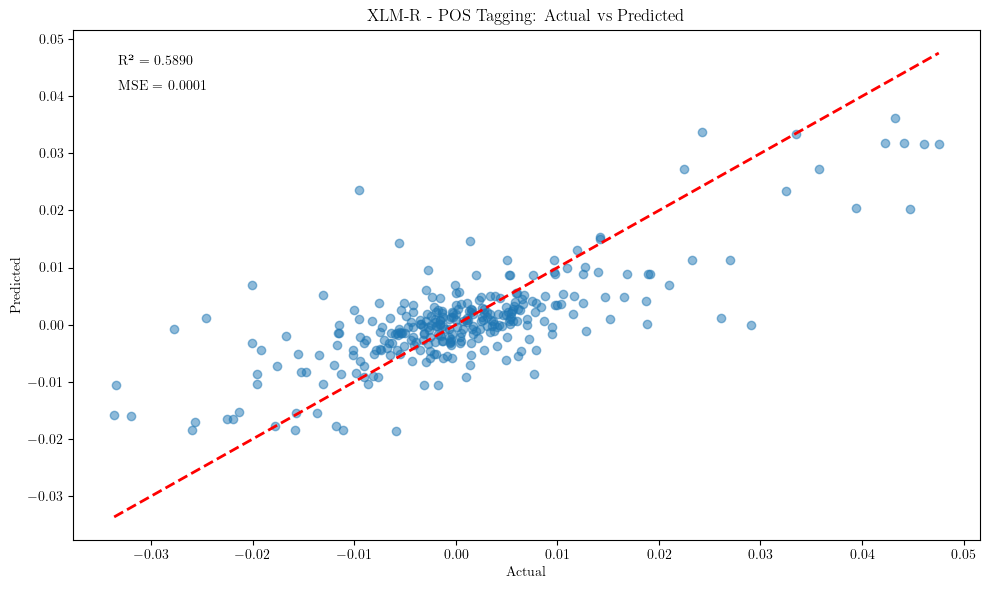

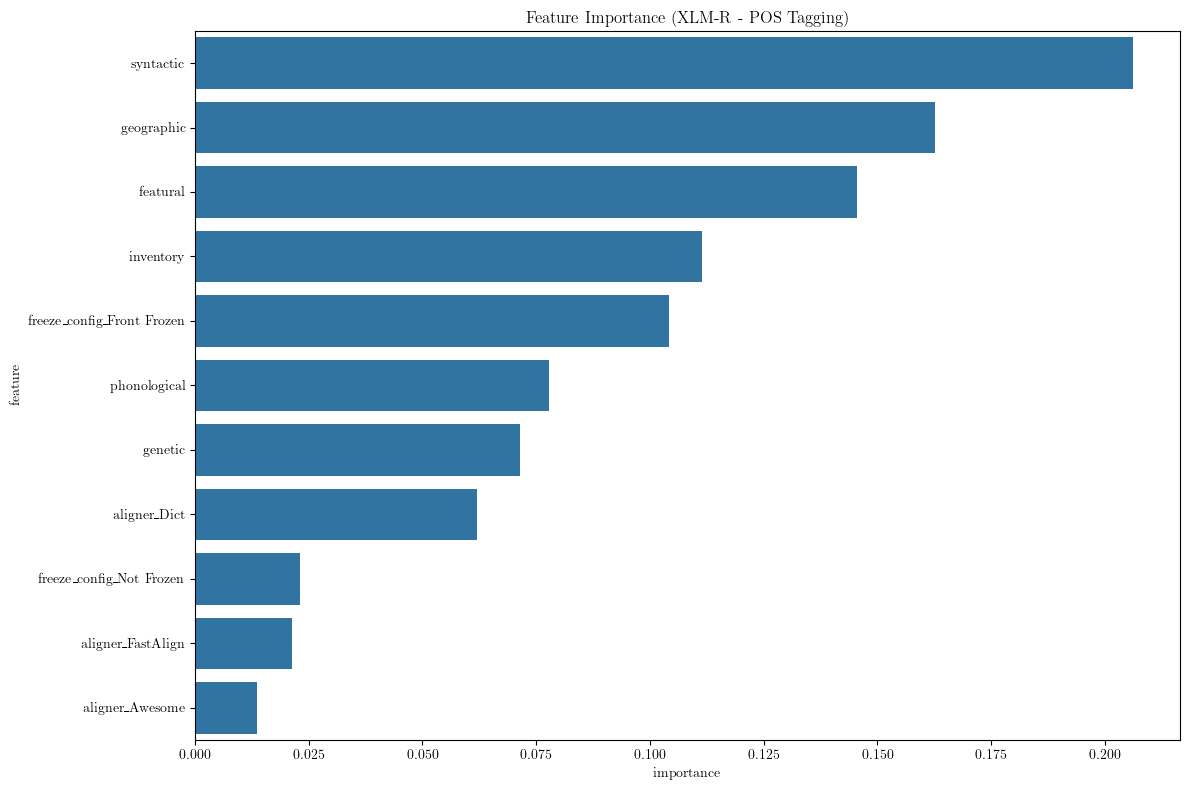

In [26]:
# Prepare features and encode categorical variables for XLM-R POS tagging
aligner_encoded = pd.get_dummies(xlmr_pos_df['aligner'], prefix='aligner', drop_first=False)
freeze_config_encoded = pd.get_dummies(xlmr_pos_df['freeze_config'], prefix='freeze_config', drop_first=True)

xlmr_pos_encoded = pd.concat([
    aligner_encoded,
    freeze_config_encoded,
    xlmr_pos_df[['syntactic', 'geographic', 'phonological', 'genetic', 'inventory', 'featural']]
], axis=1)

# Add the target variable to the encoded dataframe
xlmr_pos_encoded['delta_accuracy'] = xlmr_pos_df['delta_accuracy']

# Print the columns to verify
print(xlmr_pos_encoded.columns)

# Plot feature correlations for XLM-R POS tagging
plot_feature_correlations(xlmr_pos_encoded, xlmr_pos_encoded.columns, 'XLM-R - POS Tagging')
plot_feature_correlations(xlmr_pos_encoded, xlmr_pos_encoded.columns, 'XLM-R - POS Tagging', method='spearman')

# Prepare data for XLM-R POS tagging regression
X_xlmr_pos = xlmr_pos_encoded.drop('delta_accuracy', axis=1)
y_xlmr_pos = xlmr_pos_encoded['delta_accuracy']

# Split XLM-R POS tagging data into train, validation, and test sets
X_train_xlmr_pos, X_val_xlmr_pos, X_test_xlmr_pos, y_train_xlmr_pos, y_val_xlmr_pos, y_test_xlmr_pos = split_data(X_xlmr_pos, y_xlmr_pos)

# Tune and train XLM-R POS tagging model
print("Tuning XLM-R POS tagging model with cross-validation...")
model_xlmr_pos = tune_random_forest_with_cv(X_xlmr_pos, y_xlmr_pos)

# Make XLM-R POS tagging predictions on test set
y_pred_xlmr_pos = model_xlmr_pos.predict(X_test_xlmr_pos)

# Evaluate on test set
test_score_xlmr_pos = model_xlmr_pos.score(X_test_xlmr_pos, y_test_xlmr_pos)
print(f"XLM-R POS Tagging Test R² score: {test_score_xlmr_pos:.4f}")

# Plot XLM-R POS tagging results
plot_loss_curves(model_xlmr_pos, X_train_xlmr_pos, y_train_xlmr_pos, X_val_xlmr_pos, y_val_xlmr_pos)
plot_actual_vs_predicted(y_test_xlmr_pos, y_pred_xlmr_pos, 'XLM-R - POS Tagging: Actual vs Predicted')

# Calculate feature importance for XLM-R POS tagging
feature_importance_xlmr_pos = pd.DataFrame({'feature': X_xlmr_pos.columns, 'importance': model_xlmr_pos.feature_importances_})
feature_importance_xlmr_pos = feature_importance_xlmr_pos.sort_values('importance', ascending=False)

# Plot feature importance for XLM-R POS tagging
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_xlmr_pos)
plt.title('Feature Importance (XLM-R - POS Tagging)')
plt.tight_layout()
plt.show()

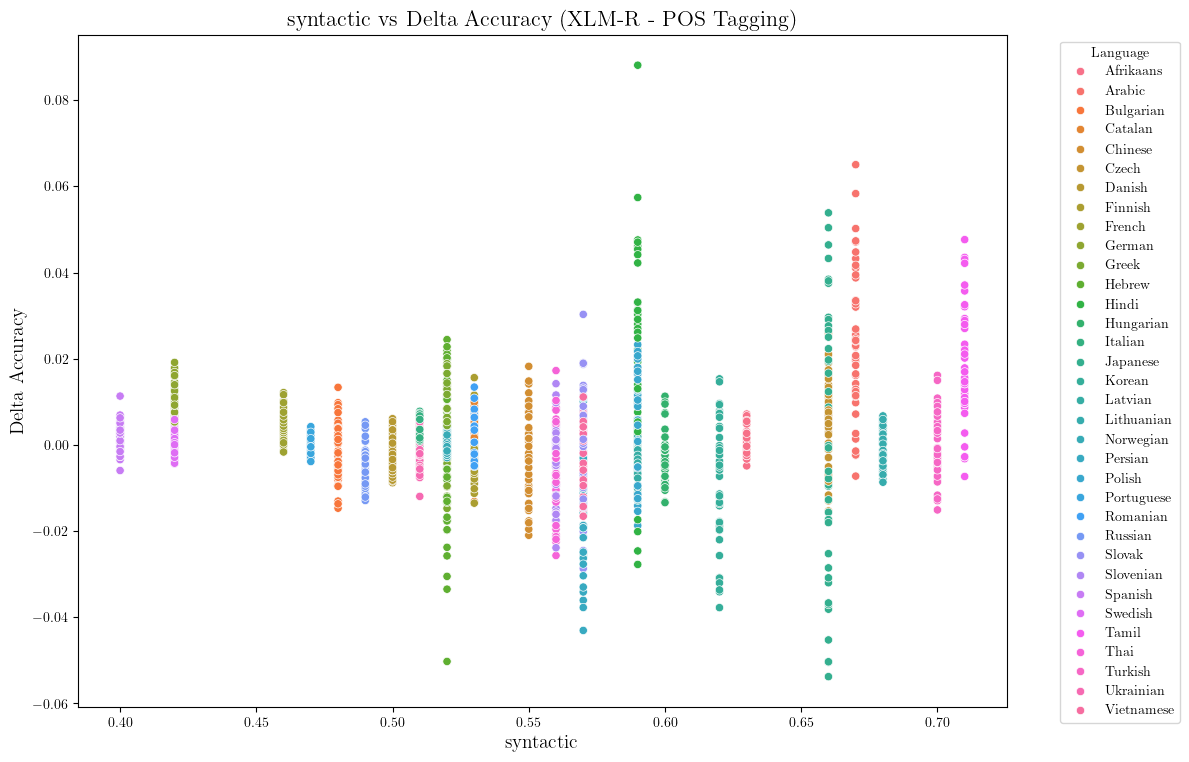

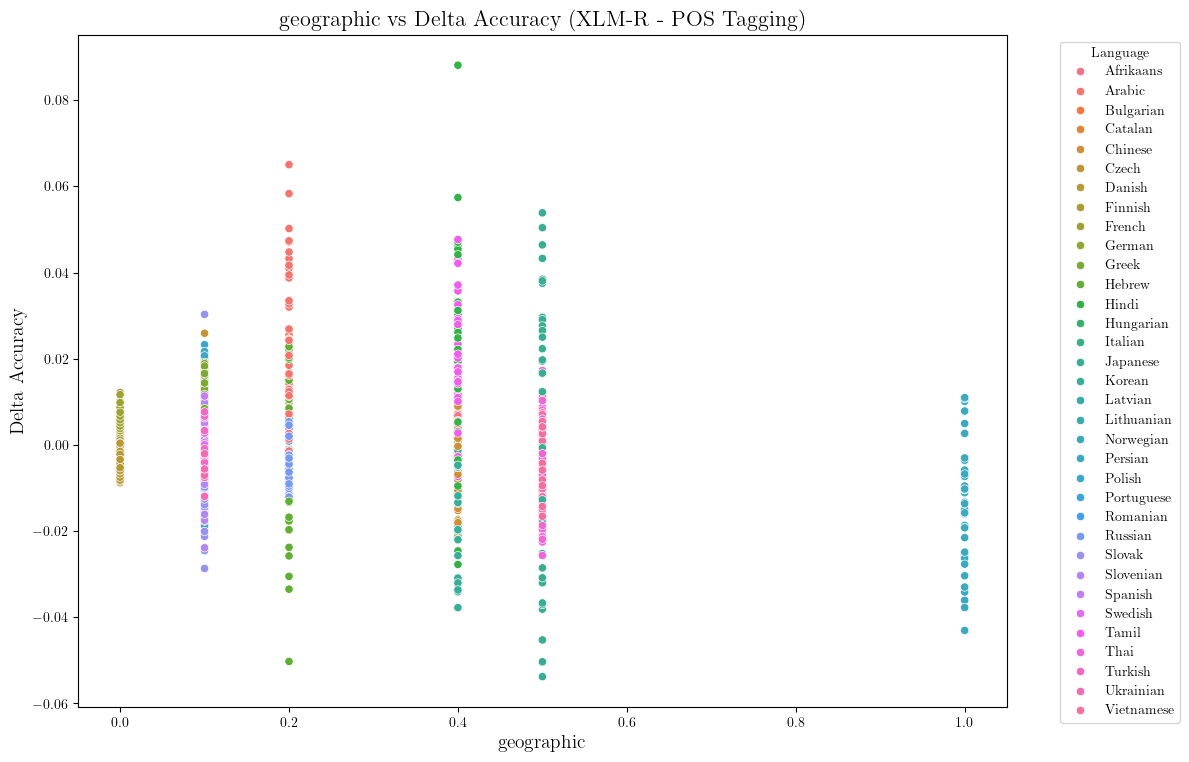

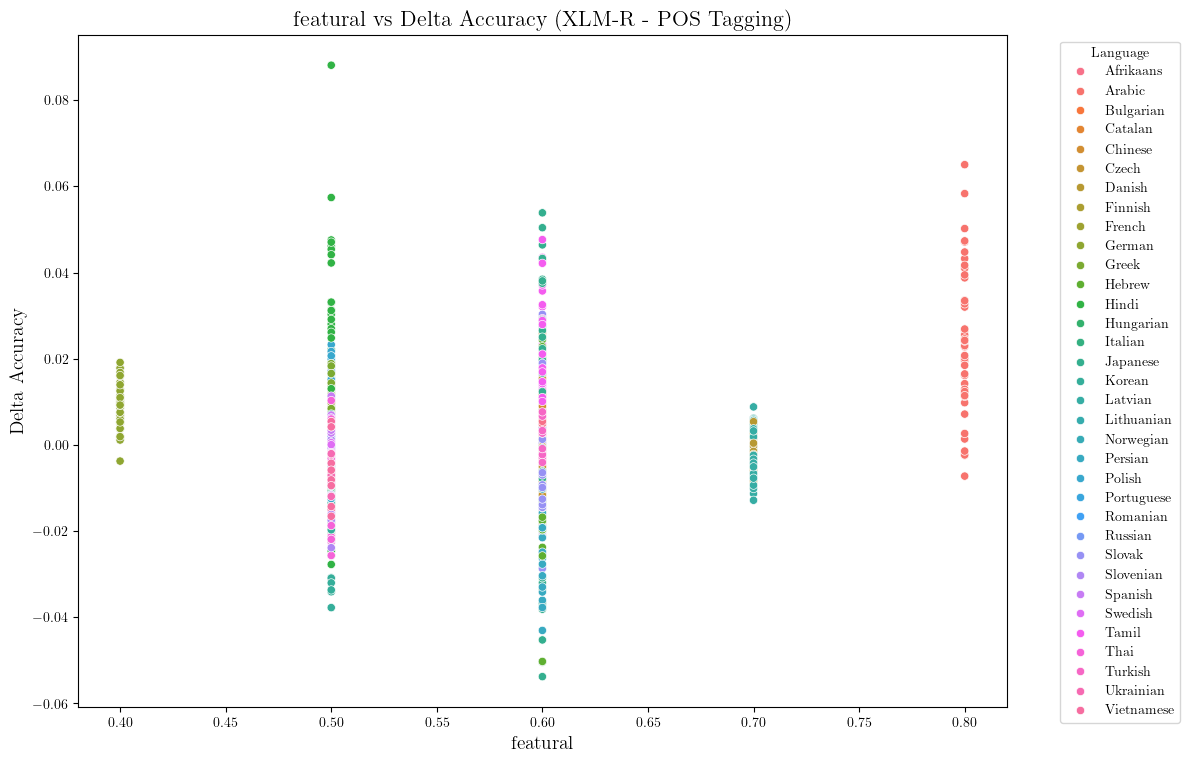

In [27]:
# For XLM-R POS tagging
# Get top 3 features
top_3_features_pos = feature_importance_xlmr_pos['feature'].head(3).tolist()

# Create separate scatter plots for top 3 features vs delta accuracy
for feature in top_3_features_pos:
    plt.figure(figsize=(12, 8))
    scatter = sns.scatterplot(data=xlmr_pos_df, x=feature, y='delta_accuracy', hue='language')
    plt.title(f'{feature} vs Delta Accuracy (XLM-R - POS Tagging)', fontsize=16)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Delta Accuracy', fontsize=14)
    
    # Adjust legend
    scatter.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    plt.tight_layout()
    plt.show()

Index(['aligner_Awesome', 'aligner_Dict', 'aligner_FastAlign',
       'freeze_config_Front Frozen', 'freeze_config_Not Frozen', 'syntactic',
       'geographic', 'phonological', 'genetic', 'inventory', 'featural',
       'delta_accuracy'],
      dtype='object')


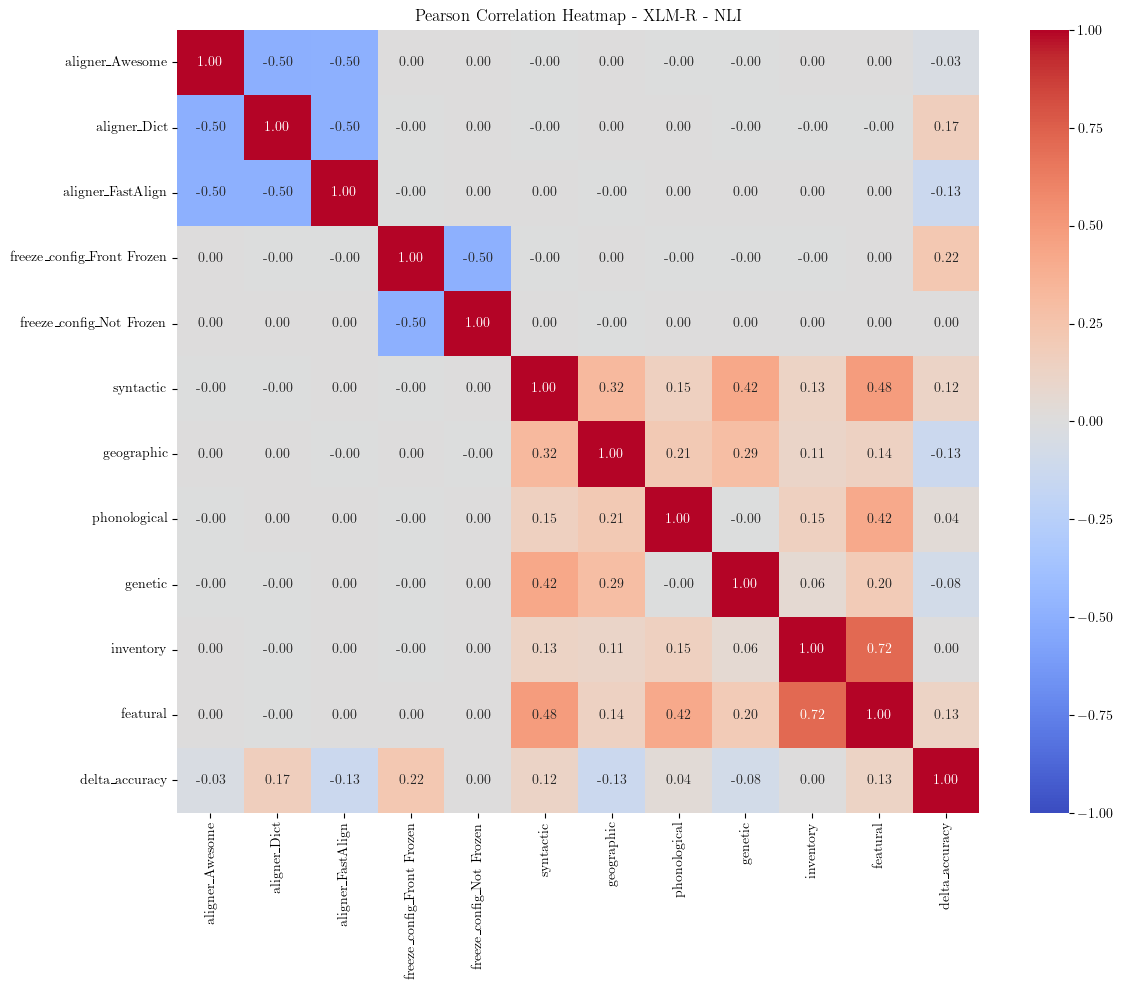

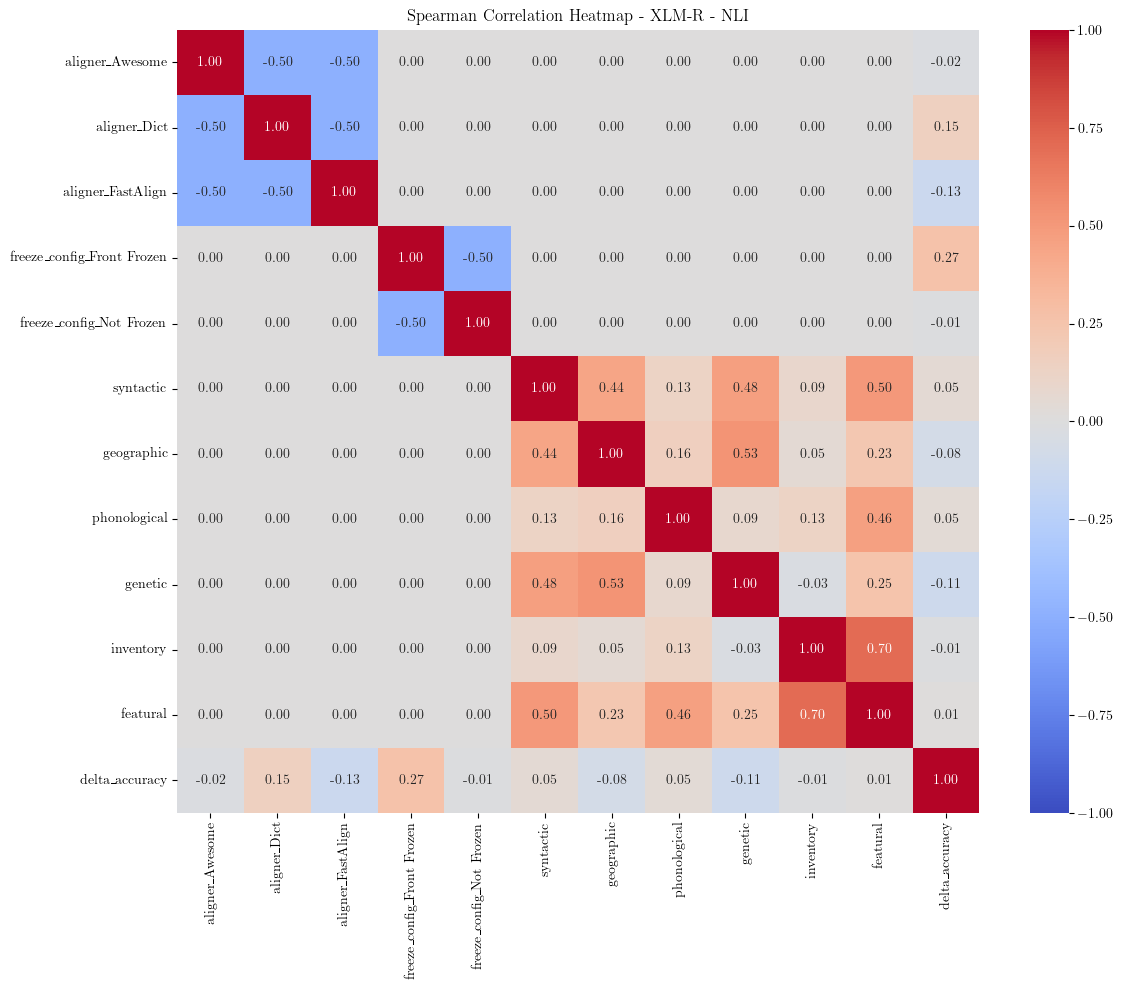

Tuning XLM-R NLI model with cross-validation...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 6, 'n_estimators': 327}
Cross-validation R² scores: [0.33699801 0.44962116 0.4820163  0.40024834 0.43792849]
Mean R² score: 0.4214 (+/- 0.0993)
XLM-R NLI Test R² score: 0.4519


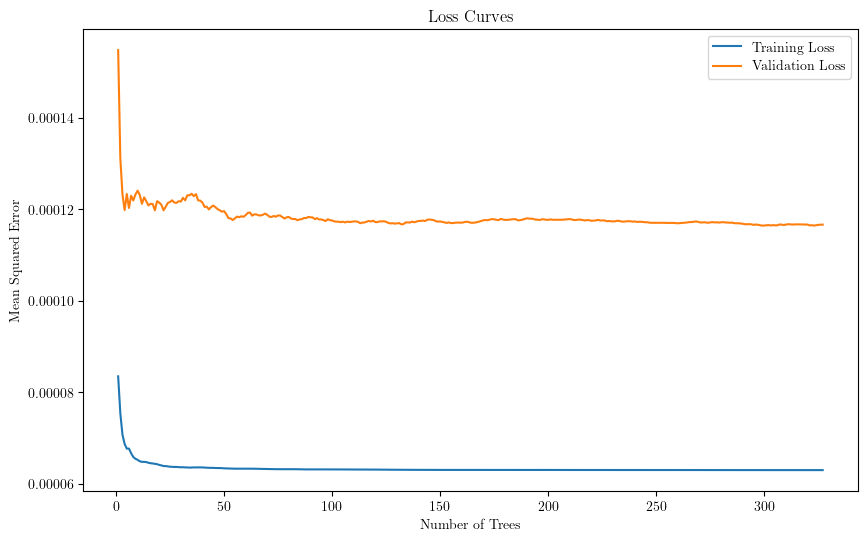

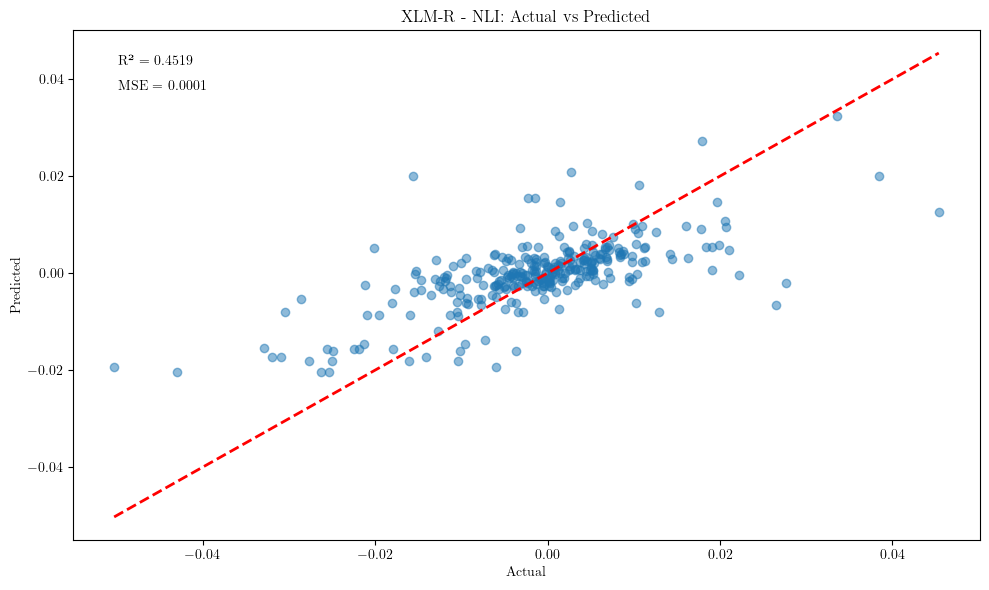

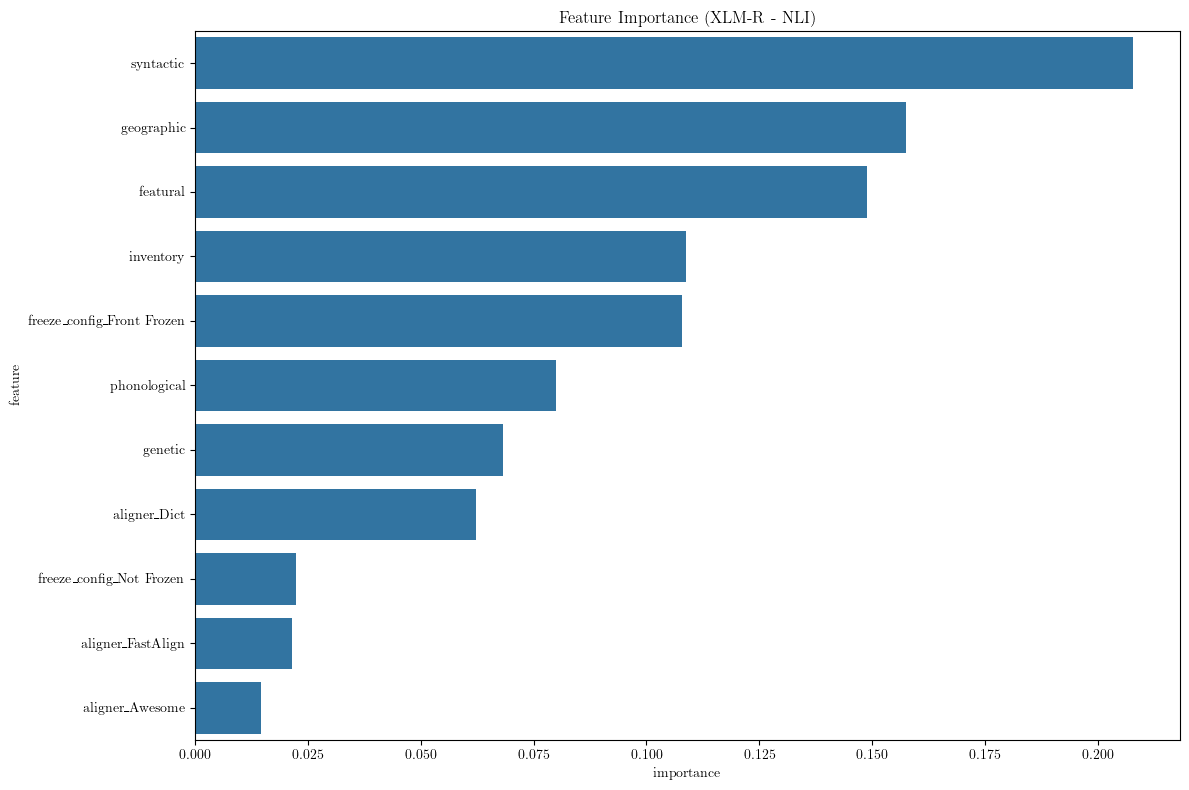

In [30]:
# Prepare features and encode categorical variables for XLM-R NLI
aligner_encoded_nli = pd.get_dummies(xlmr_nli_df['aligner'], prefix='aligner', drop_first=False)
freeze_config_encoded_nli = pd.get_dummies(xlmr_nli_df['freeze_config'], prefix='freeze_config', drop_first=True)

xlmr_nli_encoded = pd.concat([
    aligner_encoded_nli,
    freeze_config_encoded_nli,
    xlmr_nli_df[['syntactic', 'geographic', 'phonological', 'genetic', 'inventory', 'featural']]
], axis=1)

# Add the target variable to the encoded dataframe
xlmr_nli_encoded['delta_accuracy'] = xlmr_nli_df['delta_accuracy']

# Print the columns to verify
print(xlmr_nli_encoded.columns)

# Plot feature correlations for XLM-R NLI
plot_feature_correlations(xlmr_nli_encoded, xlmr_nli_encoded.columns, 'XLM-R - NLI')
plot_feature_correlations(xlmr_nli_encoded, xlmr_nli_encoded.columns, 'XLM-R - NLI', method='spearman')

# Prepare data for XLM-R NLI regression
X_xlmr_nli = xlmr_nli_encoded.drop('delta_accuracy', axis=1)
y_xlmr_nli = xlmr_nli_encoded['delta_accuracy']

# Split XLM-R NLI data into train, validation, and test sets
X_train_xlmr_nli, X_val_xlmr_nli, X_test_xlmr_nli, y_train_xlmr_nli, y_val_xlmr_nli, y_test_xlmr_nli = split_data(X_xlmr_nli, y_xlmr_nli)

# Tune and train XLM-R NLI model
print("Tuning XLM-R NLI model with cross-validation...")
model_xlmr_nli = tune_random_forest_with_cv(X_xlmr_nli, y_xlmr_nli)

# Make XLM-R NLI predictions on test set
y_pred_xlmr_nli = model_xlmr_nli.predict(X_test_xlmr_nli)

# Evaluate on test set
test_score_xlmr_nli = model_xlmr_nli.score(X_test_xlmr_nli, y_test_xlmr_nli)
print(f"XLM-R NLI Test R² score: {test_score_xlmr_nli:.4f}")

# Plot XLM-R NLI results
plot_loss_curves(model_xlmr_nli, X_train_xlmr_nli, y_train_xlmr_nli, X_val_xlmr_nli, y_val_xlmr_nli)
plot_actual_vs_predicted(y_test_xlmr_nli, y_pred_xlmr_nli, 'XLM-R - NLI: Actual vs Predicted')

# Calculate feature importance for XLM-R NLI
feature_importance_xlmr_nli = pd.DataFrame({'feature': X_xlmr_nli.columns, 'importance': model_xlmr_nli.feature_importances_})
feature_importance_xlmr_nli = feature_importance_xlmr_nli.sort_values('importance', ascending=False)

# Plot feature importance for XLM-R NLI
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_xlmr_nli)
plt.title('Feature Importance (XLM-R - NLI)')
plt.tight_layout()
plt.show()

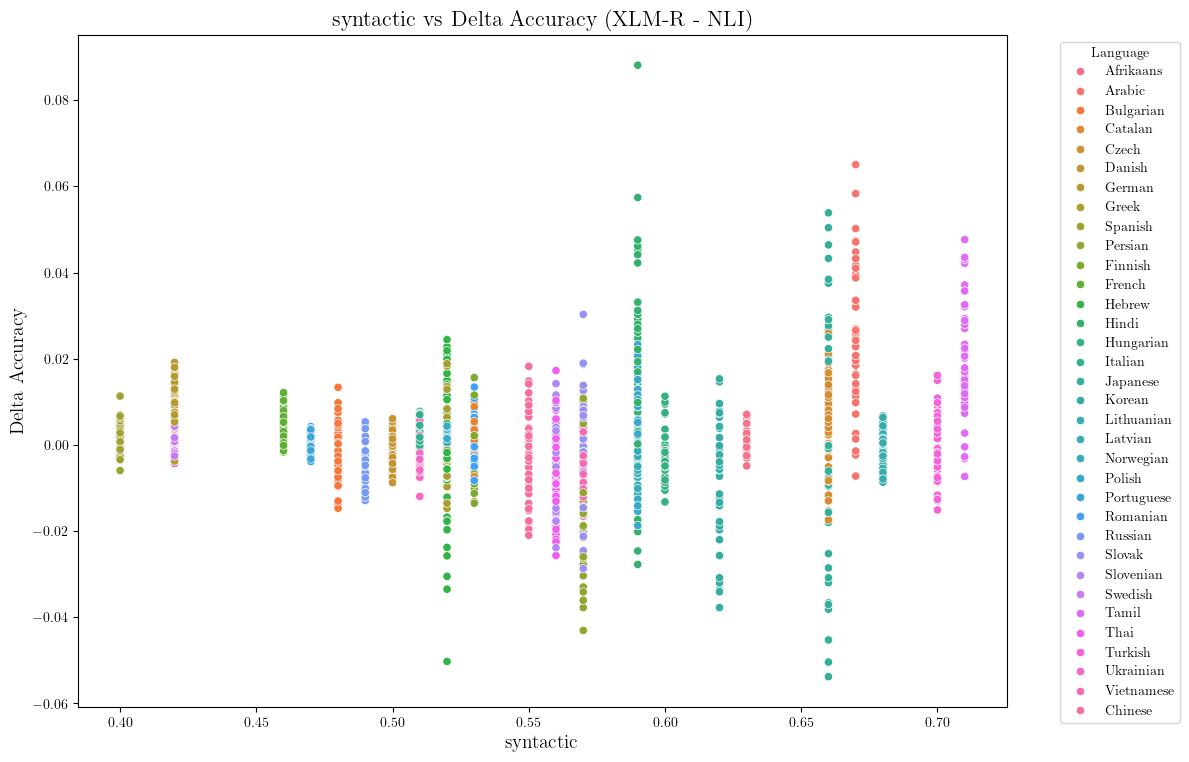

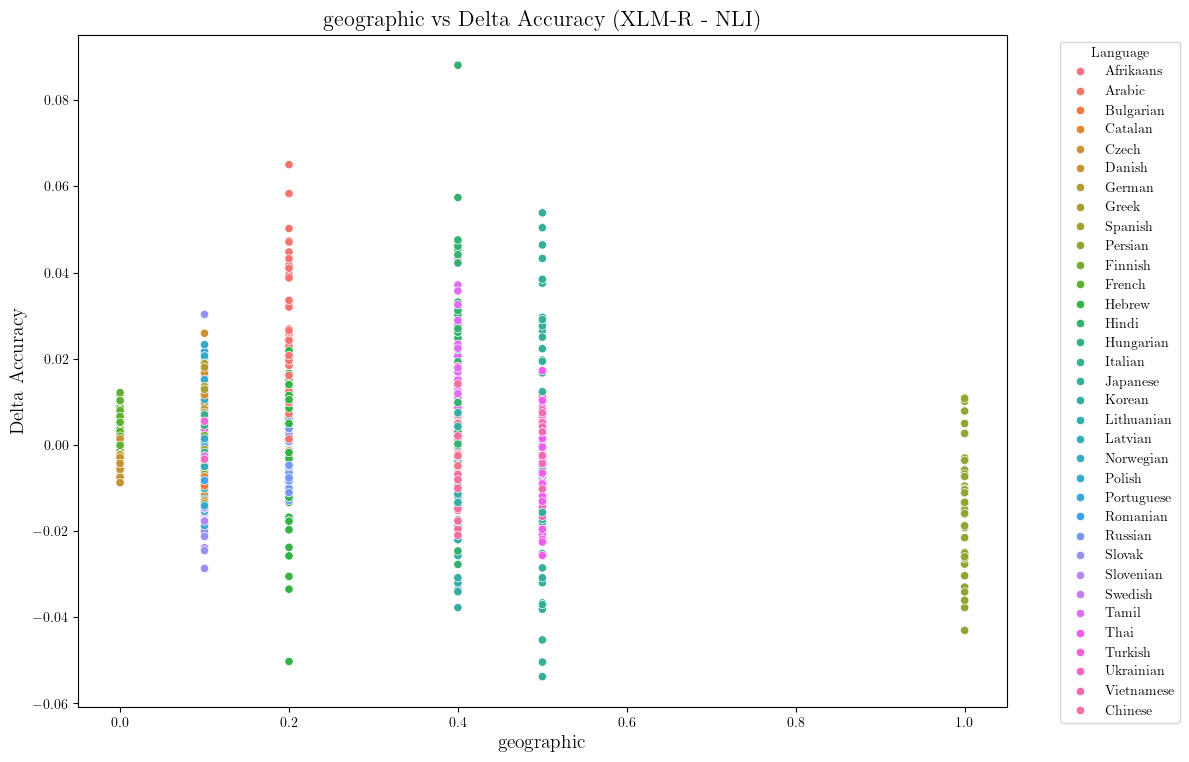

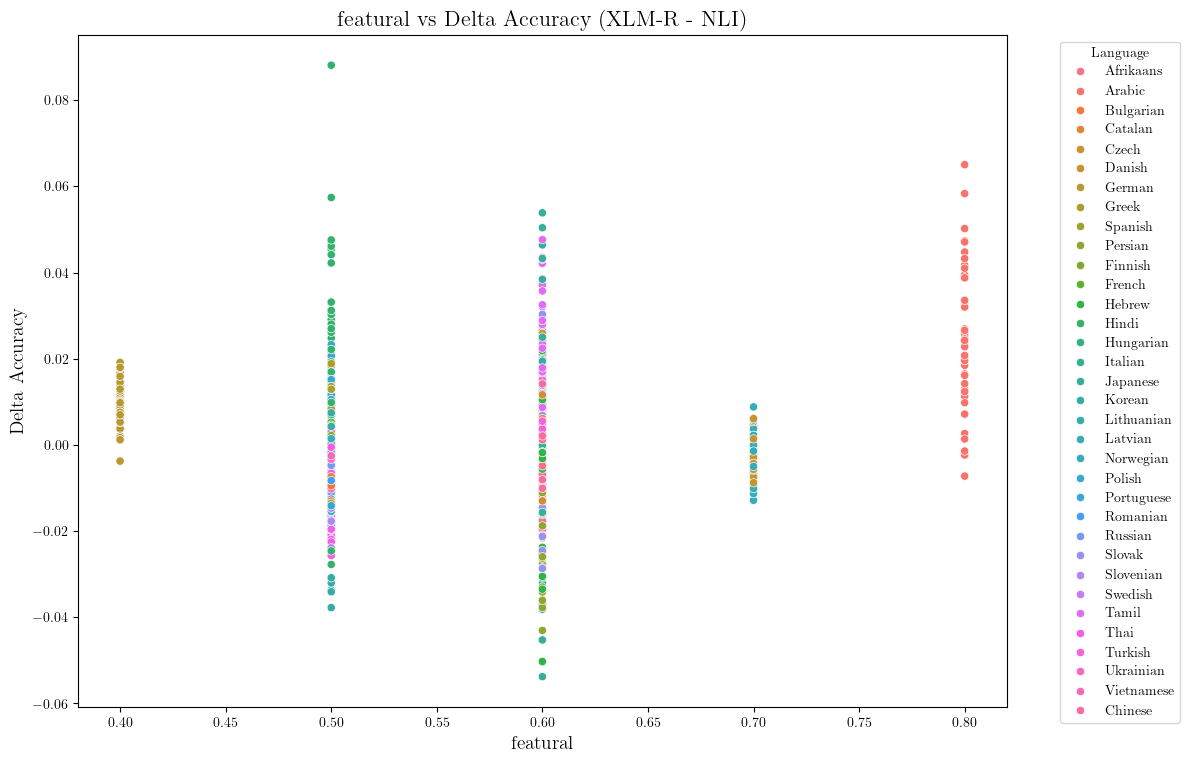

In [31]:
# For XLM-R NLI
# Get top 3 features
top_3_features_nli = feature_importance_xlmr_nli['feature'].head(3).tolist()

# Create separate scatter plots for top 3 features vs delta accuracy
for feature in top_3_features_nli:
    plt.figure(figsize=(12, 8))
    scatter = sns.scatterplot(data=xlmr_nli_df, x=feature, y='delta_accuracy', hue='language')
    plt.title(f'{feature} vs Delta Accuracy (XLM-R - NLI)', fontsize=16)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Delta Accuracy', fontsize=14)
    
    # Adjust legend
    scatter.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    plt.tight_layout()
    plt.show()

DistilmBERT Data:
Original data points: 1530


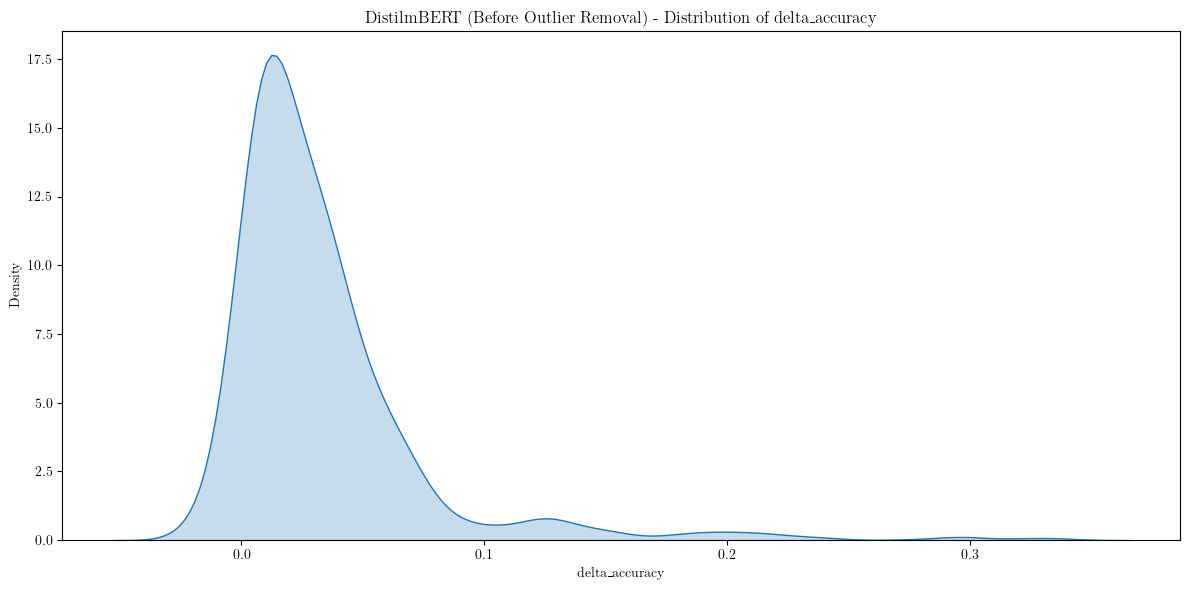

Outlier bounds for delta_accuracy: [-0.037694, 0.088682]
Data points after outlier removal: 1429

Number of rows removed per language (DistilmBERT):
language
Thai          45
Arabic        40
Latvian        9
Korean         3
Hindi          2
Lithuanian     2
Name: count, dtype: int64


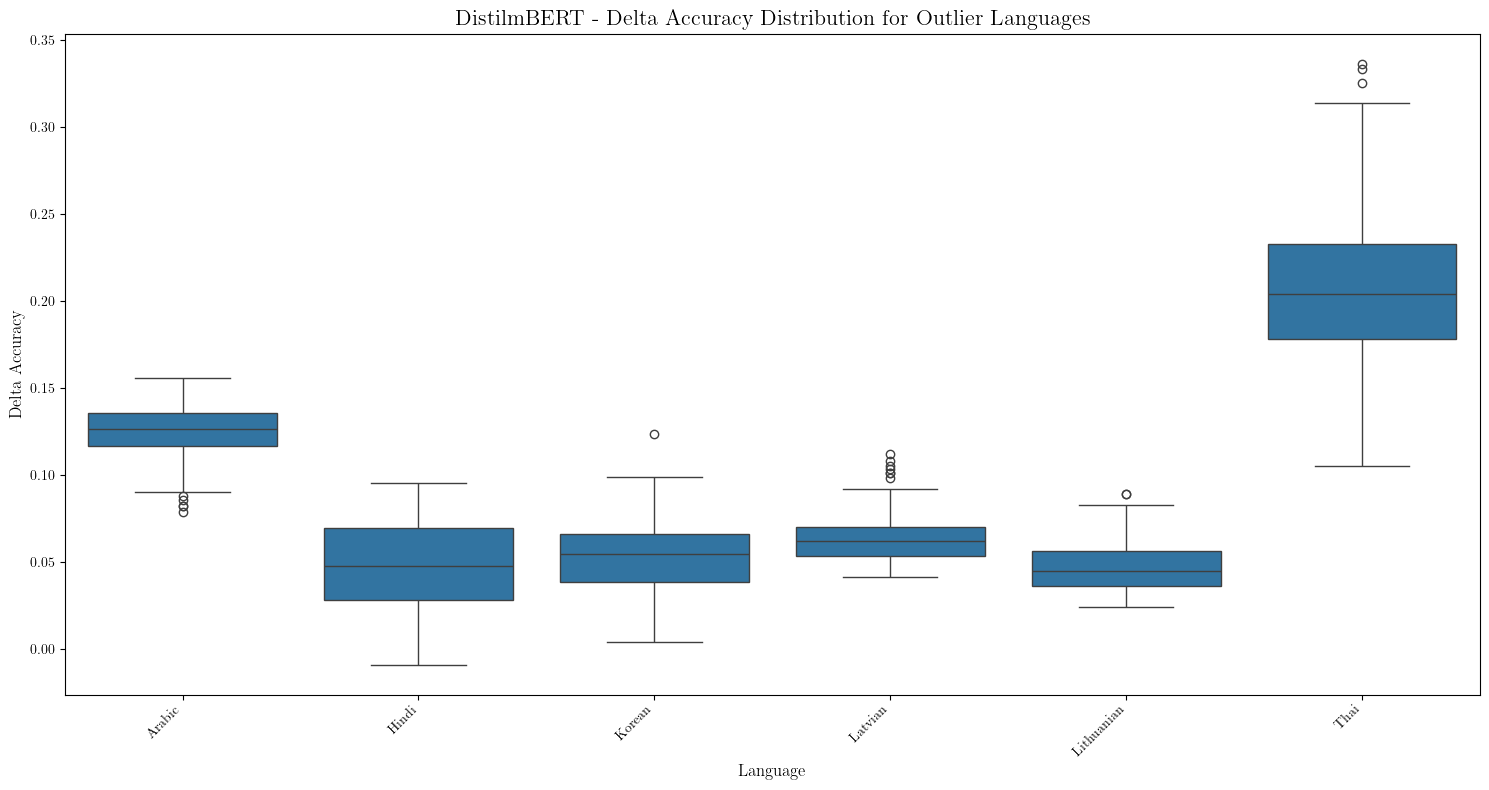

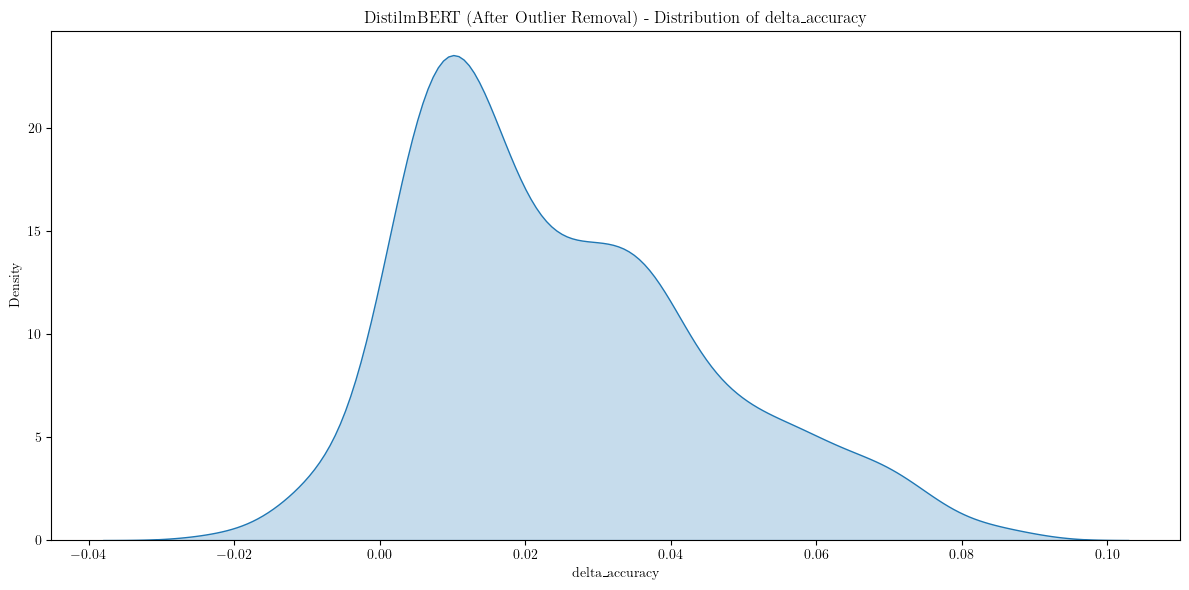


NLI Data:
Original data points: 540


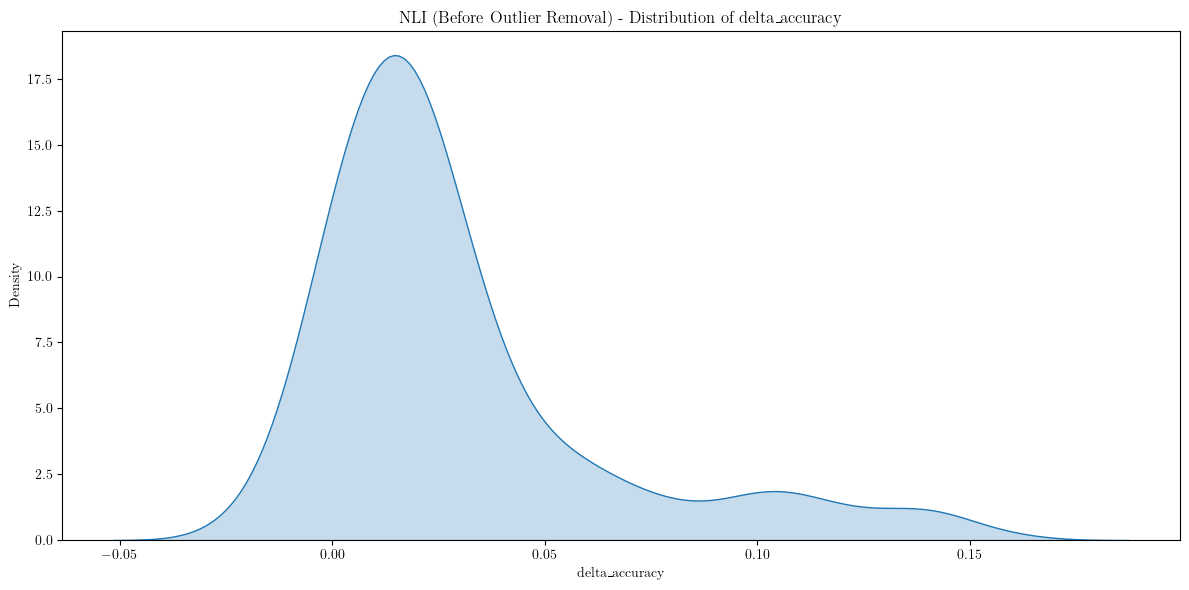

Outlier bounds for delta_accuracy: [-0.035429, 0.080339]
Data points after outlier removal: 483

Number of rows removed per language (NLI):
language
Thai          37
Vietnamese    20
Name: count, dtype: int64


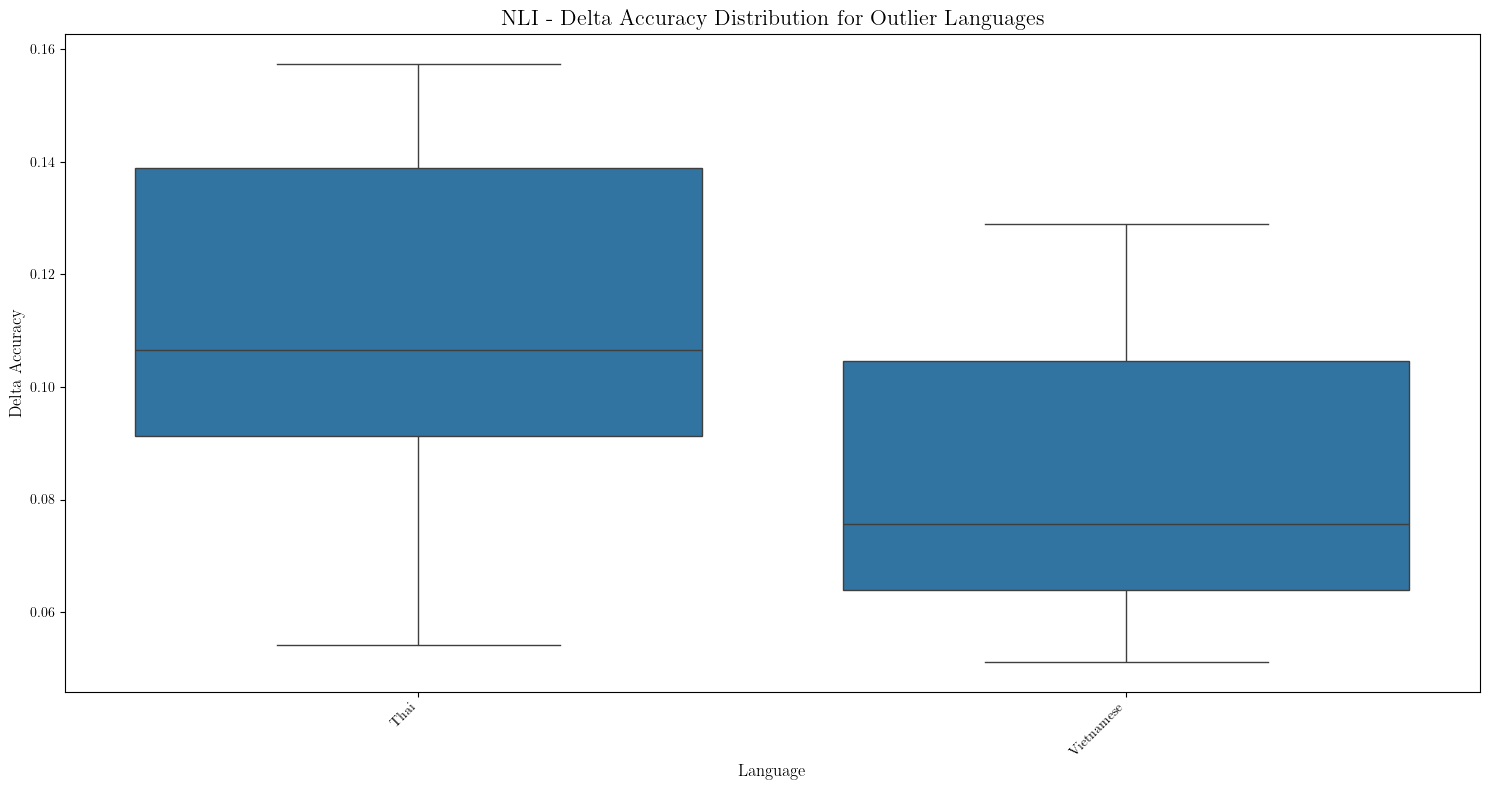

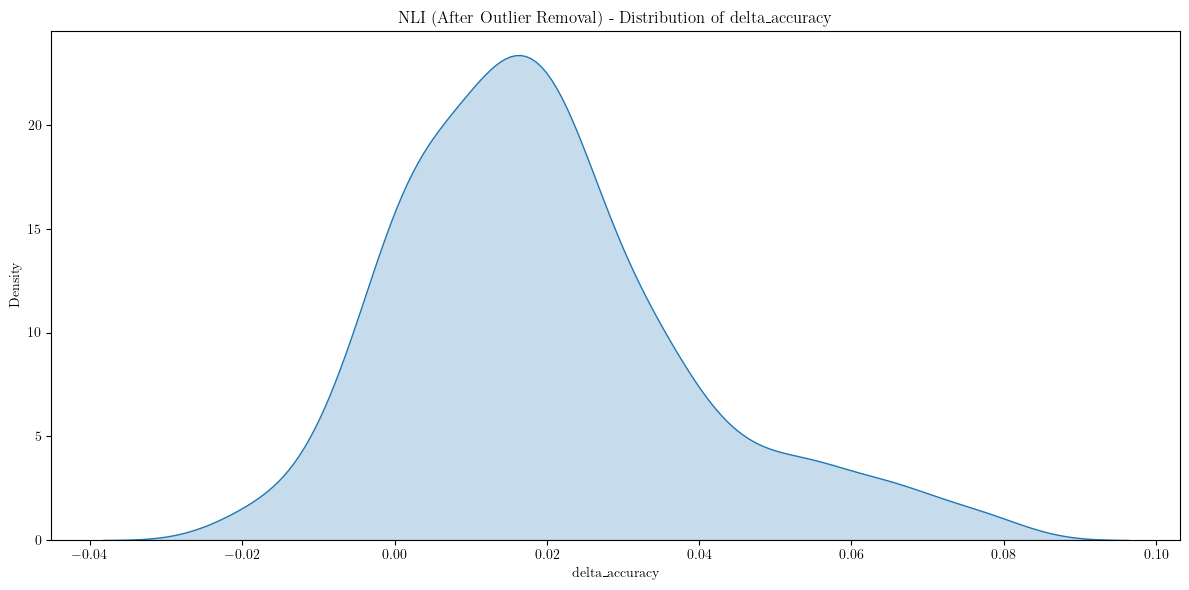

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def remove_outliers_and_count(df, column='delta_accuracy'):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    print(f"Outlier bounds for {column}: [{lower_bound:.6f}, {upper_bound:.6f}]")
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    df_clean = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    removed_counts = outliers['language'].value_counts()
    
    return df_clean, removed_counts, outliers

def plot_outlier_languages(df, outliers, title):
    if outliers.empty:
        print(f"No outliers found for {title}")
        return
    
    plt.figure(figsize=(15, 8))
    sns.boxplot(x='language', y='delta_accuracy', data=df[df['language'].isin(outliers['language'].unique())])
    plt.title(f'{title} - Delta Accuracy Distribution for Outlier Languages', fontsize=16)
    plt.xlabel('Language', fontsize=12)
    plt.ylabel('Delta Accuracy', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_kde(df, column, title):
    plt.figure(figsize=(12, 6))
    sns.kdeplot(data=df, x=column, fill=True)  # Changed 'shade' to 'fill'
    plt.title(f'{title} - Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()

# Process DistilmBERT data
print("DistilmBERT Data:")
print(f"Original data points: {len(distilmbert_df)}")
plot_kde(distilmbert_df, 'delta_accuracy', 'DistilmBERT (Before Outlier Removal)')

distilmbert_df_clean, distilmbert_removed_counts, distilmbert_outliers = remove_outliers_and_count(distilmbert_df)
print(f"Data points after outlier removal: {len(distilmbert_df_clean)}")
print("\nNumber of rows removed per language (DistilmBERT):")
print(distilmbert_removed_counts)
plot_outlier_languages(distilmbert_df, distilmbert_outliers, 'DistilmBERT')
plot_kde(distilmbert_df_clean, 'delta_accuracy', 'DistilmBERT (After Outlier Removal)')

# Process NLI data
print("\nNLI Data:")
print(f"Original data points: {len(nli_df)}")
plot_kde(nli_df, 'delta_accuracy', 'NLI (Before Outlier Removal)')

nli_df_clean, nli_removed_counts, nli_outliers = remove_outliers_and_count(nli_df)
print(f"Data points after outlier removal: {len(nli_df_clean)}")
print("\nNumber of rows removed per language (NLI):")
print(nli_removed_counts)
plot_outlier_languages(nli_df, nli_outliers, 'NLI')
plot_kde(nli_df_clean, 'delta_accuracy', 'NLI (After Outlier Removal)')